# Data import

In [ ]:
import warnings
from datetime import date

import arviz as az
import matplotlib.pylab as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import xarray as xr
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import os

# Limita a 4 core
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"

import jax
import numpyro

# Configura JAX per usare solo la CPU
jax.config.update("jax_platform_name", "cpu")

# Verifica quanti dispositivi JAX rileva
print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


In [ ]:
import numpyro
numpyro.set_host_device_count(16)
import jax
jax.config.update("jax_platform_name", "cpu")
print("JAX devices:", jax.devices())

JAX devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


In [ ]:
SEED = sum(map(ord, "Time varying parameters are awesome!"))
rng = np.random.default_rng(SEED)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100


In [ ]:
data = pd.read_excel("DB.xlsx",parse_dates=["date_start_week"])
data.set_index("date_start_week", inplace=True)

In [ ]:
periods_to_remove = data[data["Output"] == 0].index
data = data.drop(index=periods_to_remove)

we remove these observations because the output is zero and it affects its correlation with the variables and the model, but it can be used later as an unobserved test set to make forecasting

In [ ]:
print(data.columns)

Index(['year', 'week_number', 'Output', 'wl_display_awareness_impression',
       'wl_display_awareness_click', 'wl_display_awareness_sp',
       'wl_display_performance_prospecting_click',
       'wl_display_performance_prospecting_sp',
       'wl_display_performance_retargeting_click',
       'wl_display_performance_retargeting_sp', 'wl_vol_grp', 'wl_vol_sp',
       'wl_vol_impression', 'wl_ctv_grp', 'wl_ctv_sp', 'wl_ctv_impression',
       'wl_social_video_grp', 'wl_social_video_sp',
       'wl_social_video_impression', 'wl_affiliation_comparatori_click',
       'wl_affiliation_comparatori_sp', 'wl_social_awareness_impression',
       'wl_social_awareness_sp', 'wl_social_performance_click',
       'wl_social_performance_lead', 'wl_social_performance_sp',
       'wl_search_brand_impression', 'wl_search_brand_click',
       'wl_search_brand_sp', 'wl_search_market_impression',
       'wl_search_market_click', 'wl_search_market_sp',
       'wl_search_top_kwd_fastweb_impression',
       

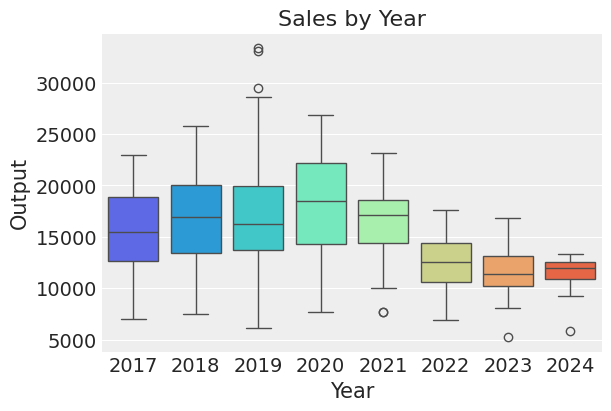

In [ ]:
# Boxplot of 'Output' by 'year'
plt.figure(figsize=(6,4))
sns.boxplot(x='year', y='Output', data=data, palette='rainbow')
plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Output')
plt.show()

# Preprocessing and Preliminary analysis

### Variables aggregation

/tmp/ipykernel_11997/92627313.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


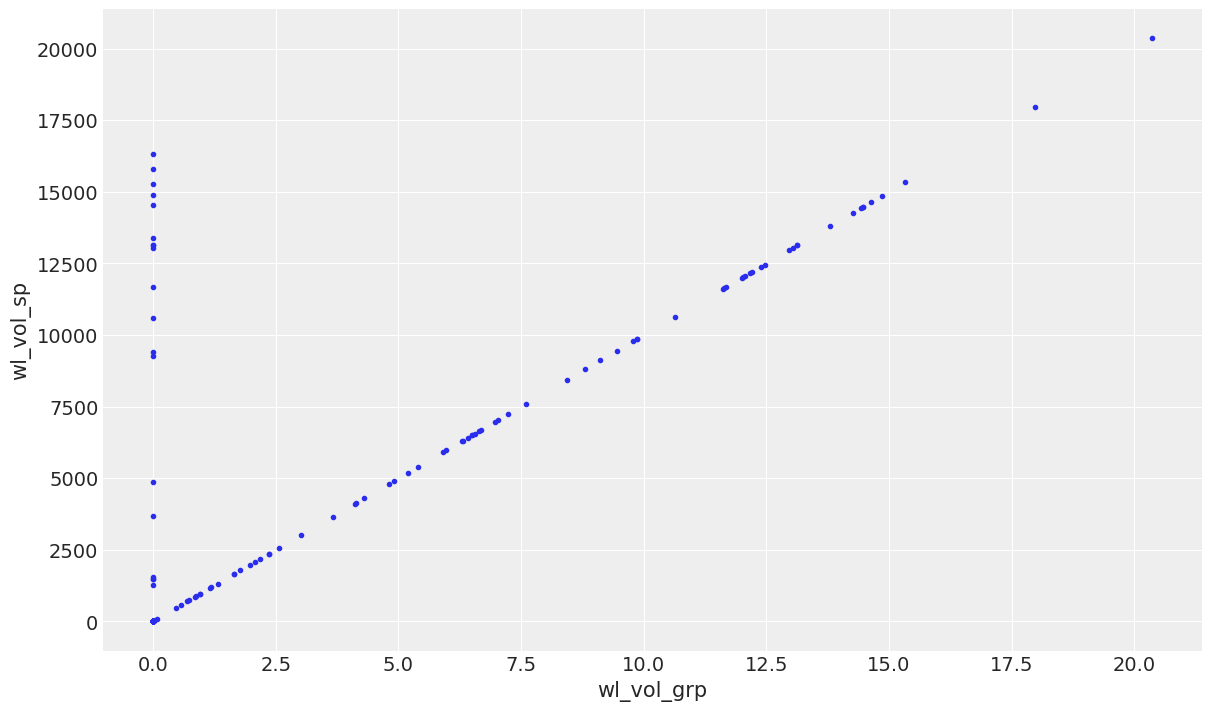

In [ ]:
plt.plot(data['wl_vol_grp'], data['wl_vol_sp'], '.')
plt.xlabel('wl_vol_grp')
plt.ylabel('wl_vol_sp')
plt.legend()
plt.show()

Completely linear dependent. Furthermore, some values of wl_vol_grp are 0 while sp not, so we delete grp

/tmp/ipykernel_11997/3893966834.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


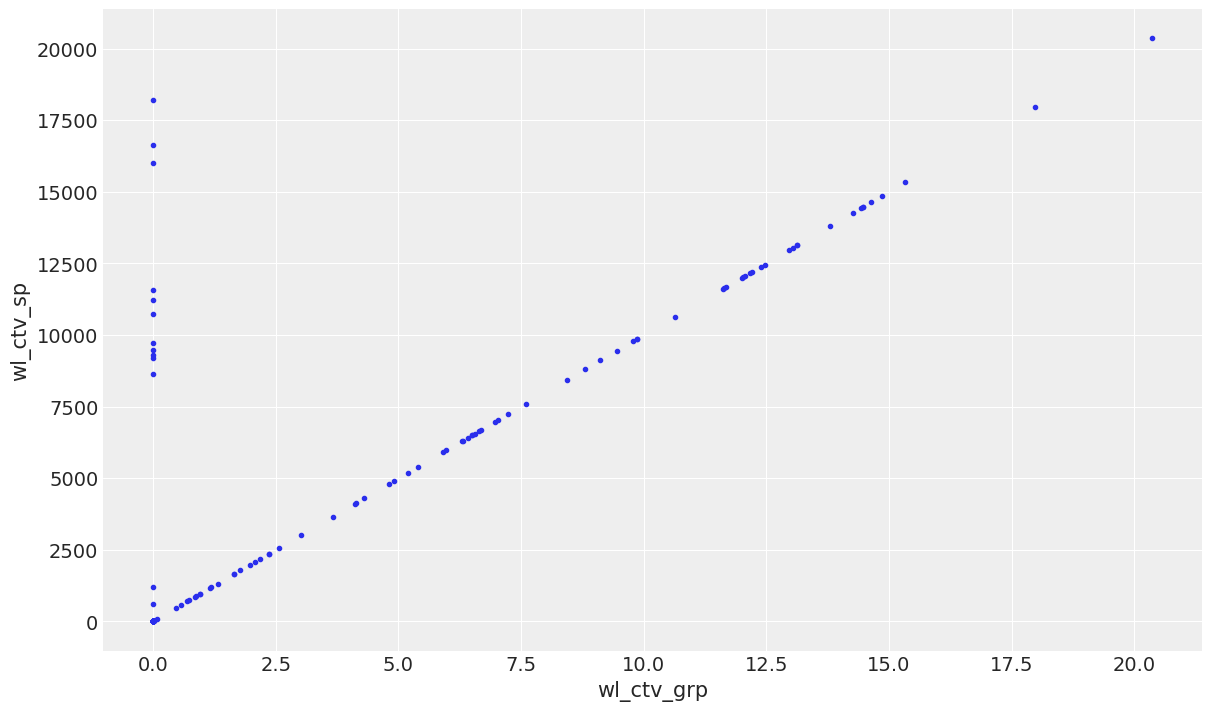

In [ ]:
plt.plot(data['wl_ctv_grp'], data['wl_ctv_sp'], '.')
plt.xlabel('wl_ctv_grp')
plt.ylabel('wl_ctv_sp')
plt.legend()
plt.show()

exactly the same

Text(0, 0.5, 'wl_ctv_sp')

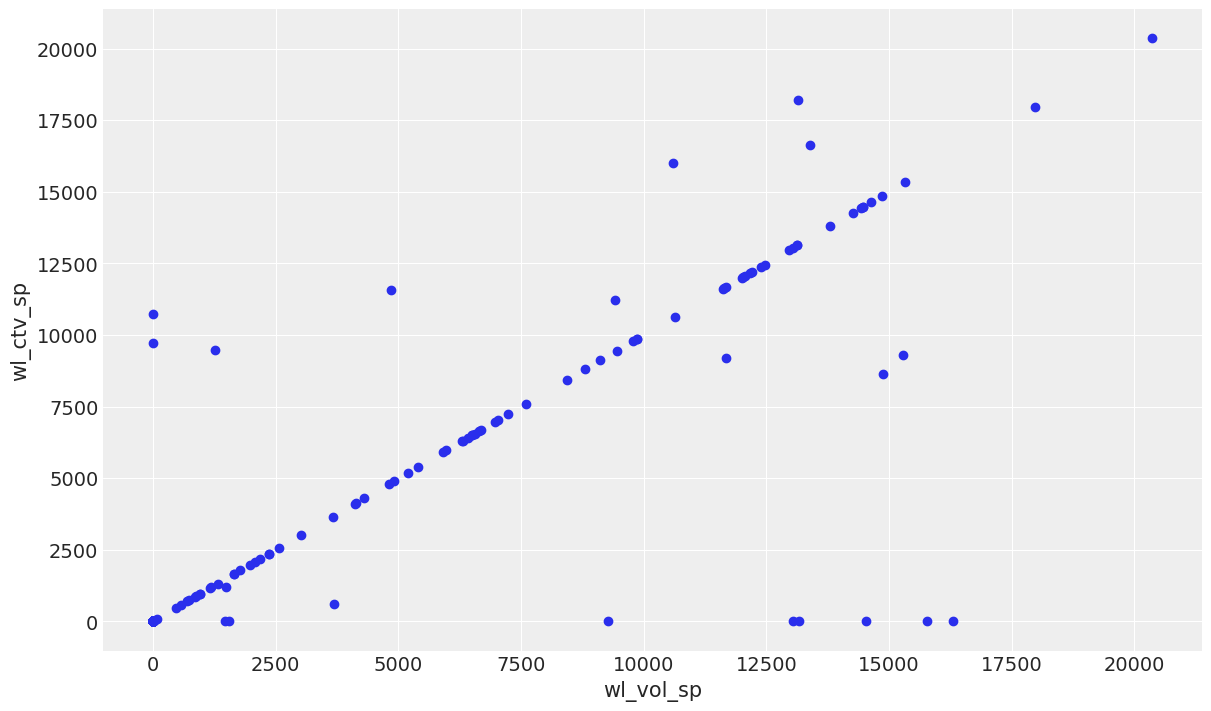

In [ ]:
plt.scatter(data['wl_vol_sp'],data['wl_ctv_sp'])
plt.xlabel('wl_vol_sp')
plt.ylabel('wl_ctv_sp')

In [ ]:
data['wl_vol_sp'].corr(data['wl_ctv_sp'])

0.8793806597586858

In [ ]:
data['wl_vol_sp'].corr(data['Output']), data['wl_ctv_sp'].corr(data['Output'])

(0.028211879305507066, 0.10843306714424608)

Since these two variables are extremely correlated, we can sum them, in order to keep both the channels, since they're different, but thinking about a single effect and coefficient on the target variable

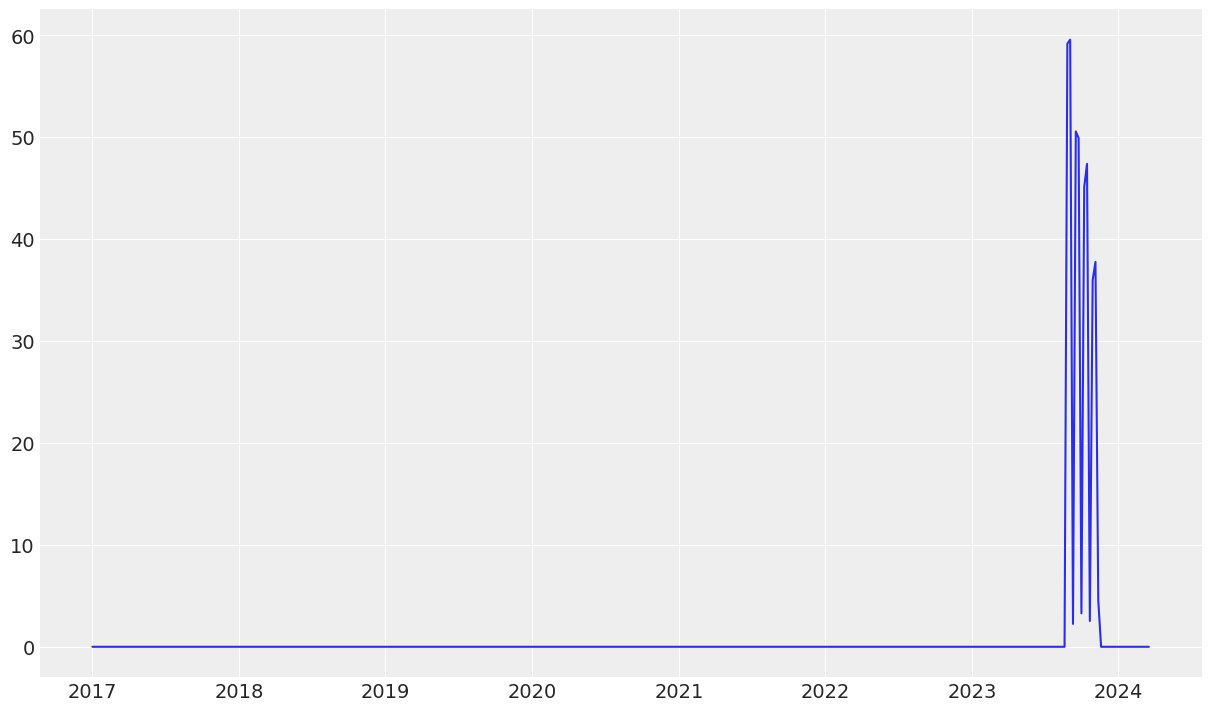

In [ ]:
plt.plot(data['tv_cross'])

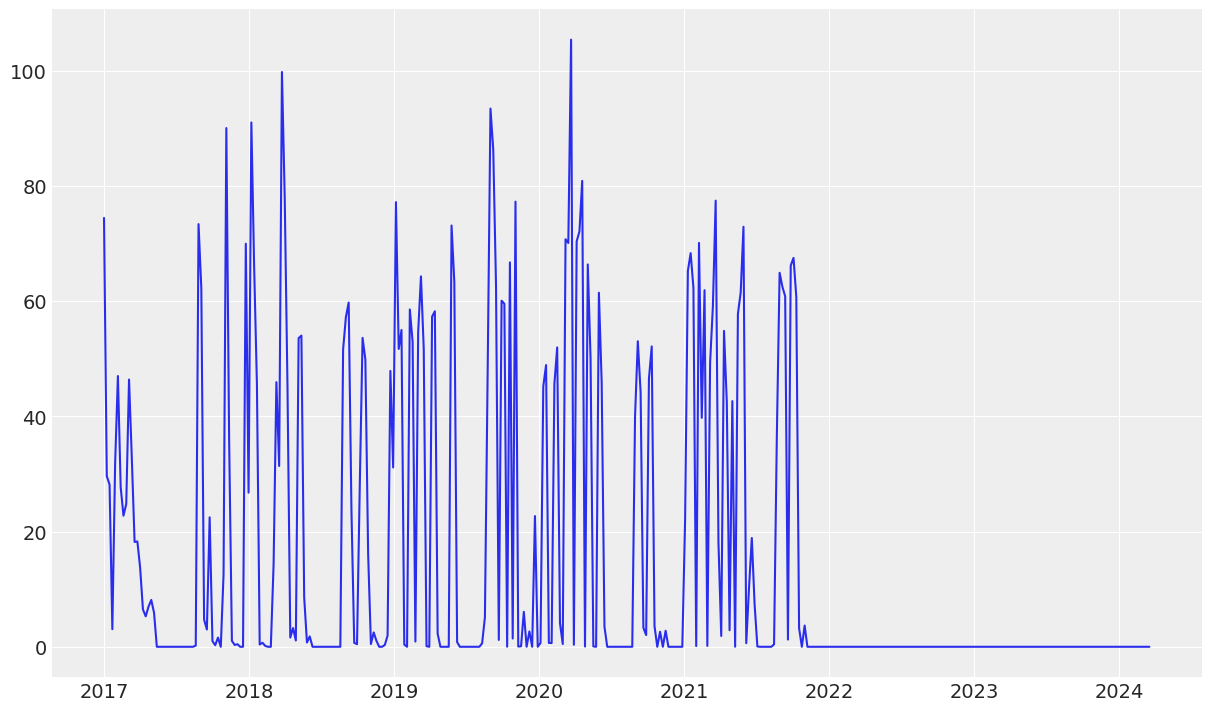

In [ ]:
plt.plot(data['tv_fibra'])

problem: tv_cross has values different from zero only in the last year, but the last observations have to be used as validation and test set.
CHANGE IN THE STRATEGY: spendings in tv_fibra have been moved to tv_cross
and their effects can be exchangeable, one affects the other
so we can sum them and consider them jointly, with a unique transformation and coefficient

In [ ]:
df = data.copy()
variables = ['year', 'week_number',
    'Output', 'wl_display_awareness_impression', 'wl_display_awareness_click',
    'wl_display_awareness_sp', 'wl_display_performance_prospecting_click',
    'wl_display_performance_prospecting_sp', 'wl_display_performance_retargeting_click',
    'wl_display_performance_retargeting_sp', 'wl_vol_sp',
    'wl_vol_impression', 'wl_ctv_sp', 'wl_ctv_impression',
    'wl_search_brand_impression', 'wl_search_brand_click', 'wl_search_brand_sp',
    'wl_search_market_impression', 'wl_search_market_click', 'wl_search_market_sp',
    'wl_search_top_kwd_fastweb_impression', 'wl_search_top_kwd_fastweb_click',
    'wl_search_top_kwd_fastweb_sp', 'tv_fibra', 'tv_istituzionale', 'tv_mobile', 'tv_cross',
    'tv_comp1_mobile', 'tv_comp1_fibra', 'tv_comp1_business',
    'tv_comp1_cross', 'tv_comp1_istituzionale', 'tv_comp2_mobile', 'tv_comp2_fibra',
    'tv_comp2_business', 'tv_comp2_cross', 'tv_comp2_istituzionale', 'tv_comp3_mobile',
    'tv_comp3_fibra', 'tv_comp3_business', 'tv_comp3_cross', 'tv_comp3_istituzionale',
    'tv_comp4_mobile', 'tv_comp4_fibra', 'tv_comp4_business', 'tv_comp4_cross',
    'tv_comp4_istituzionale', 'store_prezzo_ottico', 'store_prezzo_ottico_comp1',
    'store_prezzo_ottico_comp2', 'store_prezzo_ottico_comp3', 'store_prezzo_ottico_comp4',
    'web_prezzo_ottico', 'web_prezzo_ottico_comp1', 'web_prezzo_ottico_comp2',
    'web_prezzo_ottico_comp3'
]
df = df[variables]

df['wl_vol_ctv_sp'] = df['wl_vol_sp'] + df['wl_ctv_sp']
df['tv_fibra_cross'] = df['tv_fibra'] + df['tv_cross']

df['display_awareness_impression'] = df['wl_display_awareness_impression']
df['display_click'] = (df['wl_display_awareness_click'] + df['wl_display_performance_prospecting_click'] + df['wl_display_performance_retargeting_click'])
df['display_sp'] = (df['wl_display_performance_retargeting_sp'] + df['wl_display_awareness_sp'] + df['wl_display_performance_prospecting_sp'])

df['search_impression'] = (df['wl_search_brand_impression'] + df['wl_search_market_impression'] + df['wl_search_top_kwd_fastweb_impression'])
df['search_click'] = (df['wl_search_brand_click'] + df['wl_search_market_click'] + df['wl_search_top_kwd_fastweb_click'])
df['search_sp'] = (df['wl_search_brand_sp'] + df['wl_search_market_sp'] + df['wl_search_top_kwd_fastweb_sp'])

#control variate t
df["t"] = range(1, len(df) + 1)

final = ['Output','year', 'week_number', 't','display_awareness_impression', 'display_click', 'display_sp',
         'wl_vol_ctv_sp', #'wl_vol_sp', 'wl_ctv_sp',
         'wl_vol_impression', 'wl_ctv_impression', 'search_impression', 'search_click', 'search_sp',
         'tv_fibra_cross', #'tv_fibra', 'tv_cross',
         'tv_istituzionale', 'tv_mobile', 'tv_comp1_mobile', 'tv_comp1_fibra', 'tv_comp1_business',
         'tv_comp1_cross', 'tv_comp1_istituzionale', 'tv_comp2_mobile', 'tv_comp2_fibra',
         'tv_comp2_business', 'tv_comp2_cross', 'tv_comp2_istituzionale', 'tv_comp3_mobile',
         'tv_comp3_fibra', 'tv_comp3_business', 'tv_comp3_cross', 'tv_comp3_istituzionale',
         'tv_comp4_mobile', 'tv_comp4_fibra', 'tv_comp4_business', 'tv_comp4_cross',
         'tv_comp4_istituzionale', 'store_prezzo_ottico', 'store_prezzo_ottico_comp1',
         'store_prezzo_ottico_comp2', 'store_prezzo_ottico_comp3', 'store_prezzo_ottico_comp4',
         'web_prezzo_ottico', 'web_prezzo_ottico_comp1', 'web_prezzo_ottico_comp2', 'web_prezzo_ottico_comp3'
]
df = df[final]
print(df.columns)

Index(['Output', 'year', 'week_number', 't', 'display_awareness_impression',
       'display_click', 'display_sp', 'wl_vol_ctv_sp', 'wl_vol_impression',
       'wl_ctv_impression', 'search_impression', 'search_click', 'search_sp',
       'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile', 'tv_comp1_mobile',
       'tv_comp1_fibra', 'tv_comp1_business', 'tv_comp1_cross',
       'tv_comp1_istituzionale', 'tv_comp2_mobile', 'tv_comp2_fibra',
       'tv_comp2_business', 'tv_comp2_cross', 'tv_comp2_istituzionale',
       'tv_comp3_mobile', 'tv_comp3_fibra', 'tv_comp3_business',
       'tv_comp3_cross', 'tv_comp3_istituzionale', 'tv_comp4_mobile',
       'tv_comp4_fibra', 'tv_comp4_business', 'tv_comp4_cross',
       'tv_comp4_istituzionale', 'store_prezzo_ottico',
       'store_prezzo_ottico_comp1', 'store_prezzo_ottico_comp2',
       'store_prezzo_ottico_comp3', 'store_prezzo_ottico_comp4',
       'web_prezzo_ottico', 'web_prezzo_ottico_comp1',
       'web_prezzo_ottico_comp2', 'web_prezzo_

moltiplico per 320 i tv_channels

In [ ]:
# Lista delle colonne da moltiplicare
tv_columns = [
    'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile',
    'tv_comp1_mobile', 'tv_comp1_fibra', 'tv_comp1_business', 'tv_comp1_cross',
    'tv_comp1_istituzionale', 'tv_comp2_mobile', 'tv_comp2_fibra',
    'tv_comp2_business', 'tv_comp2_cross', 'tv_comp2_istituzionale',
    'tv_comp3_mobile', 'tv_comp3_fibra', 'tv_comp3_business', 'tv_comp3_cross',
    'tv_comp3_istituzionale', 'tv_comp4_mobile', 'tv_comp4_fibra',
    'tv_comp4_business', 'tv_comp4_cross', 'tv_comp4_istituzionale'
]

# Moltiplica le colonne selezionate per 320
df[tv_columns] = df[tv_columns] * 320


/tmp/ipykernel_11997/1930036755.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


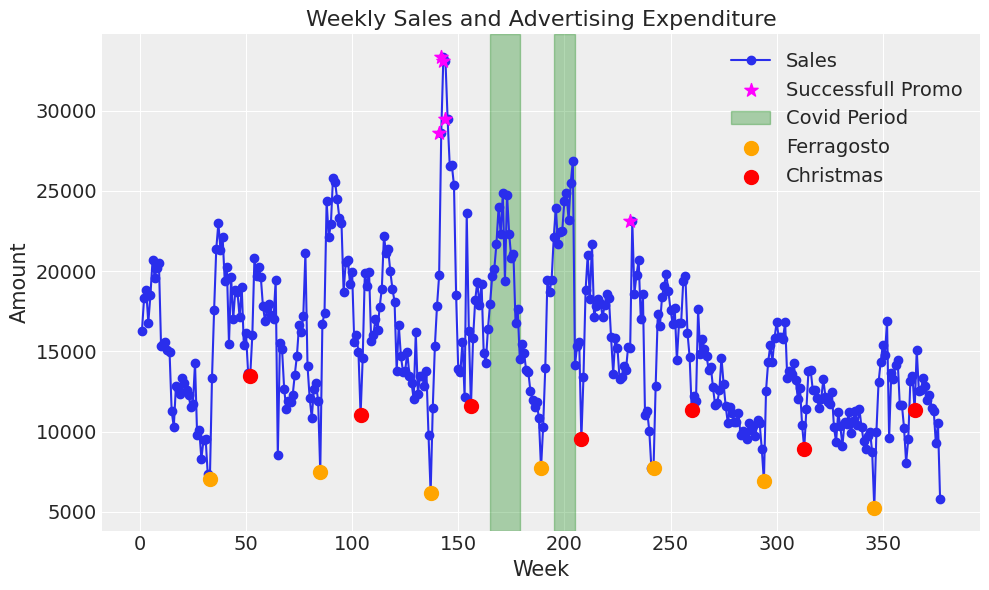

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['t'], df['Output'], label='Sales', marker='o')
# Find the top 3 sales and their corresponding 't' values
top4_sales_indices = df['Output'].nlargest(4).index
top4_sales_t_values = df['t'][top4_sales_indices]
top4_sales_t_values = [top4_sales_t_values[i]-1 for i in range(len(top4_sales_t_values))]
top4_sales_t_values.append(231)
top4_sales_values = df['Output'][top4_sales_t_values]

# Plot and annotate the top 3 sales
plt.scatter(top4_sales_t_values, top4_sales_values, color='fuchsia', marker='*', s=100, zorder=5, label='Successfull Promo') # Highlight in red

# Highlight the Covid Period
plt.axvspan(165, 179, color='green', alpha=0.3, label='Covid Period')
plt.axvspan(195, 205, color='green', alpha=0.3)

# Highlight Ferragosto dates in orange
ferragosto_dates = [33, 85, 137, 189, 242, 294, 346]
plt.scatter(ferragosto_dates, df.loc[df['t'].isin(ferragosto_dates), 'Output'], color='orange', marker='o', s=100, zorder=5, label='Ferragosto')
#Same for Christmas
christmas = [52, 104, 156, 208, 260, 313, 365]
plt.scatter(christmas, df.loc[df['t'].isin(christmas), 'Output'], color='red', marker='o', s=100, zorder=5, label='Christmas')


plt.title('Weekly Sales and Advertising Expenditure')
plt.xlabel('Week')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


dummy creation for special events

In [ ]:
df["covid19"]=0
df["special_promo"]=0
df["ferragosto" ]=0
df["christmas"]=0

df.iloc[167:179, df.columns.get_loc("covid19")] = 1
df.iloc[196:205, df.columns.get_loc("covid19")] = 1
df.iloc[top4_sales_t_values, df.columns.get_loc("special_promo")] = 1
df.iloc[ferragosto_dates, df.columns.get_loc("ferragosto")] = 1
df.iloc[christmas, df.columns.get_loc("christmas")] = 1

groups of columns

In [ ]:
# modello completo
channel_columns = ['display_awareness_impression',
       'display_click', 'display_sp',  'wl_vol_impression', 'wl_vol_ctv_sp', #'wl_vol_sp', 'wl_ctv_sp',
        'wl_ctv_impression', 'search_impression', 'search_click',
       'search_sp', 'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile']
control_columns = ['year', 'week_number','t','covid19', 'special_promo','ferragosto','christmas']
competitors_columns = ['tv_comp1_mobile', 'tv_comp1_fibra', 'tv_comp1_business',
       'tv_comp1_cross', 'tv_comp1_istituzionale', 'tv_comp2_mobile',
       'tv_comp2_fibra', 'tv_comp2_business', 'tv_comp2_cross',
       'tv_comp2_istituzionale', 'tv_comp3_mobile', 'tv_comp3_fibra',
       'tv_comp3_business', 'tv_comp3_cross', 'tv_comp3_istituzionale',
       'tv_comp4_mobile', 'tv_comp4_fibra', 'tv_comp4_business', #all zero in training
       'tv_comp4_cross', 'tv_comp4_istituzionale']
price_columns = ['store_prezzo_ottico',
       'store_prezzo_ottico_comp1', 'store_prezzo_ottico_comp2',
       'store_prezzo_ottico_comp3', 'store_prezzo_ottico_comp4',
       'web_prezzo_ottico', 'web_prezzo_ottico_comp1',
       'web_prezzo_ottico_comp2', 'web_prezzo_ottico_comp3']

In [ ]:
# Crea una copia del dataset originale
df_new = df.copy()

# Liste delle colonne principali e delle componenti
store_columns = [
    'store_prezzo_ottico', 'store_prezzo_ottico_comp1',
    'store_prezzo_ottico_comp2', 'store_prezzo_ottico_comp3',
    'store_prezzo_ottico_comp4'
]
web_columns = [
    'web_prezzo_ottico', 'web_prezzo_ottico_comp1',
    'web_prezzo_ottico_comp2', 'web_prezzo_ottico_comp3'
]

# Calcola i delta per 'store_prezzo_ottico' e relative componenti
for i, comp_col in enumerate(store_columns[1:], start=1):  # Esclude la colonna principale
    delta_col = f"delta_store_comp{i}"  # Nome della nuova colonna delta
    df_new[delta_col] = df_new['store_prezzo_ottico'] - df_new[comp_col]

# Calcola i delta per 'web_prezzo_ottico' e relative componenti
for i, comp_col in enumerate(web_columns[1:], start=1):  # Esclude la colonna principale
    delta_col = f"delta_web_comp{i}"  # Nome della nuova colonna delta
    df_new[delta_col] = df_new['web_prezzo_ottico'] - df_new[comp_col]

# Liste delle colonne da eliminare
columns_to_remove =  web_columns[1:] + store_columns[1:]

# Rimuovi le colonne delle componenti originali
df = df_new.drop(columns=columns_to_remove)

# Verifica il nuovo dataset
print(df.columns)

Index(['Output', 'year', 'week_number', 't', 'display_awareness_impression',
       'display_click', 'display_sp', 'wl_vol_ctv_sp', 'wl_vol_impression',
       'wl_ctv_impression', 'search_impression', 'search_click', 'search_sp',
       'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile', 'tv_comp1_mobile',
       'tv_comp1_fibra', 'tv_comp1_business', 'tv_comp1_cross',
       'tv_comp1_istituzionale', 'tv_comp2_mobile', 'tv_comp2_fibra',
       'tv_comp2_business', 'tv_comp2_cross', 'tv_comp2_istituzionale',
       'tv_comp3_mobile', 'tv_comp3_fibra', 'tv_comp3_business',
       'tv_comp3_cross', 'tv_comp3_istituzionale', 'tv_comp4_mobile',
       'tv_comp4_fibra', 'tv_comp4_business', 'tv_comp4_cross',
       'tv_comp4_istituzionale', 'store_prezzo_ottico', 'web_prezzo_ottico',
       'covid19', 'special_promo', 'ferragosto', 'christmas',
       'delta_store_comp1', 'delta_store_comp2', 'delta_store_comp3',
       'delta_store_comp4', 'delta_web_comp1', 'delta_web_comp2',
       'delt

In [ ]:
df["max_delta_store_comp"]=df[['delta_store_comp1', 'delta_store_comp2', 'delta_store_comp1','delta_store_comp4']].max(axis=1)
df["max_delta_web_comp"]=df[['delta_web_comp1', 'delta_web_comp2', 'delta_web_comp3']].max(axis=1)

df["tot_tv_comp_fibra"]=df[['tv_comp1_fibra', 'tv_comp2_fibra', 'tv_comp3_fibra','tv_comp4_fibra']].sum(axis=1)
df["tot_tv_comp_mobile"]=df[['tv_comp1_mobile', 'tv_comp2_mobile', 'tv_comp3_mobile','tv_comp4_mobile']].sum(axis=1)
df["tot_tv_comp_business"]=df[['tv_comp1_business', 'tv_comp2_business', 'tv_comp3_business','tv_comp4_business']].sum(axis=1)
df["tot_tv_comp_cross"]=df[['tv_comp1_cross', 'tv_comp2_cross', 'tv_comp3_cross','tv_comp4_cross']].sum(axis=1)
df["tot_tv_comp_fibra_cross"]=df[['tot_tv_comp_cross','tot_tv_comp_fibra']].sum(axis=1)
df["tot_tv_comp_istituzionale"]=df[['tv_comp1_istituzionale', 'tv_comp2_istituzionale', 'tv_comp3_istituzionale','tv_comp4_istituzionale']].sum(axis=1)

In [ ]:
# initial group of variables that we'll use in the models
channel_columns = [ 'display_sp', 'wl_vol_ctv_sp', 'search_sp', 'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile']
media_columns = [ 'display_sp', 'wl_vol_ctv_sp', 'search_sp'] #in case of different processing for media and tv variables
tv_columns=['tv_fibra_cross', 'tv_istituzionale', 'tv_mobile']

#CONTROL
control_columns = ['covid19', 'special_promo','ferragosto','christmas'] #without t, year and week number 'easter'

#COMPETITORS
#competitors_columns unchanged
competitors_columns = ['tot_tv_comp_fibra_cross','tot_tv_comp_fibra','tot_tv_comp_mobile','tot_tv_comp_business','tot_tv_comp_cross','tot_tv_comp_istituzionale','tv_comp1_mobile', 'tv_comp1_fibra',  'tv_comp2_mobile','tv_comp2_fibra', 'tv_comp3_mobile', 'tv_comp3_fibra','tv_comp4_mobile', 'tv_comp4_fibra', ]
#competitors_columns = ['tv_comp1_mobile', 'tv_comp1_fibra',  'tv_comp2_mobile','tv_comp2_fibra', 'tv_comp3_mobile', 'tv_comp3_fibra','tv_comp4_mobile', 'tv_comp4_fibra', ]
#competitors_columns = ['tot_tv_comp_fibra_cross','tot_tv_comp_fibra','tot_tv_comp_mobile','tot_tv_comp_business','tot_tv_comp_cross','tot_tv_comp_istituzionale']
#competitors_columns = ['tv_comp1_mobile', 'tv_comp1_fibra', 'tv_comp1_business','tv_comp1_cross', 'tv_comp1_istituzionale', ]

#PRICE
price_columns = ['store_prezzo_ottico', 'web_prezzo_ottico','max_delta_store_comp','max_delta_web_comp','delta_store_comp1', 'delta_store_comp2', 'delta_store_comp3','delta_store_comp4', 'delta_web_comp1','delta_web_comp2', 'delta_web_comp3']
#price_columns = ['store_prezzo_ottico', 'web_prezzo_ottico','delta_store_comp1', 'delta_store_comp2', 'delta_store_comp3','delta_store_comp4', 'delta_web_comp1','delta_web_comp2', 'delta_web_comp3']
#price_columns = ['store_prezzo_ottico', 'web_prezzo_ottico','max_delta_store_comp','max_delta_web_comp']
#price_columns = ['store_prezzo_ottico', 'web_prezzo_ottico','delta_store_comp1',  'delta_web_comp1']


### Preliminar variables importance

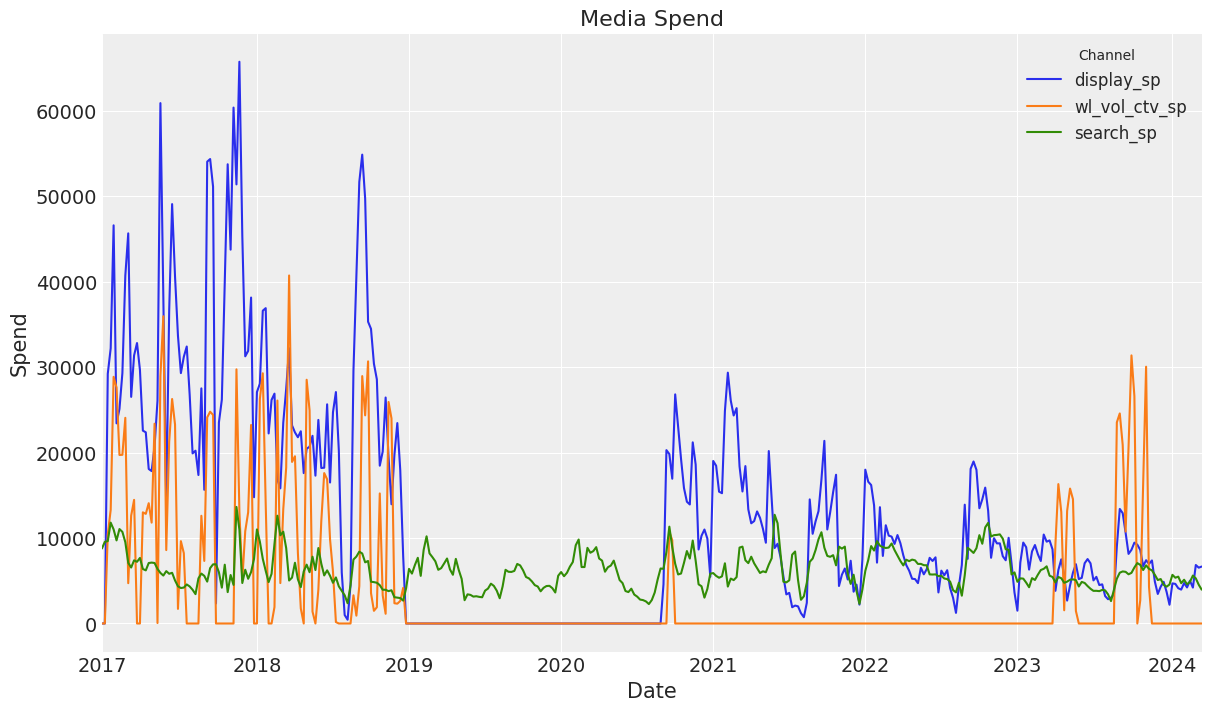

In [ ]:
fig, ax = plt.subplots()
df[media_columns].plot(ax=ax)
ax.legend(title="Channel", fontsize=12)
ax.set(title="Media Spend", xlabel="Date", ylabel="Spend");

In MMMs, the importance of a media spend variable is in part determined by its range -> display could be the most important, while vol the least

---> High variance of media variables. This suggests that it's better if we use **saturation transformation first, then adstock**

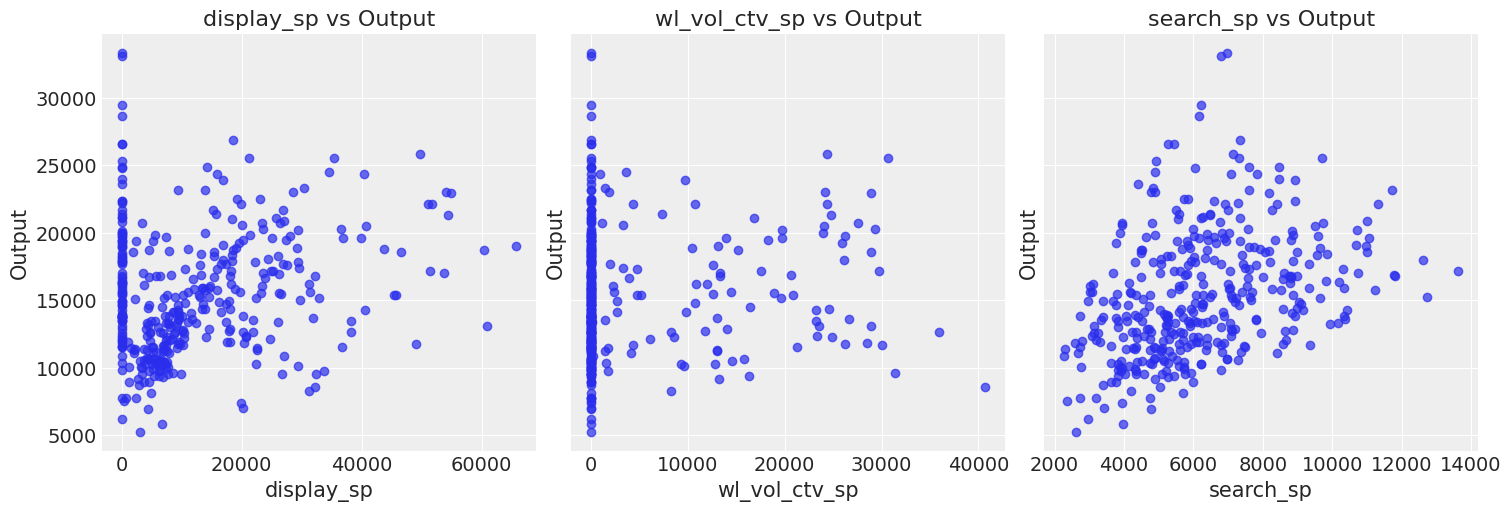

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

axes = axes.ravel()

for i, col in enumerate(media_columns):
    axes[i].scatter(df[col], df['Output'], alpha=0.7)
    axes[i].set(title=f"{col} vs Output", xlabel=col, ylabel="Output")

plt.show()

display and search spendings seem to be the most effective on the output. in display the saturation effect is clear

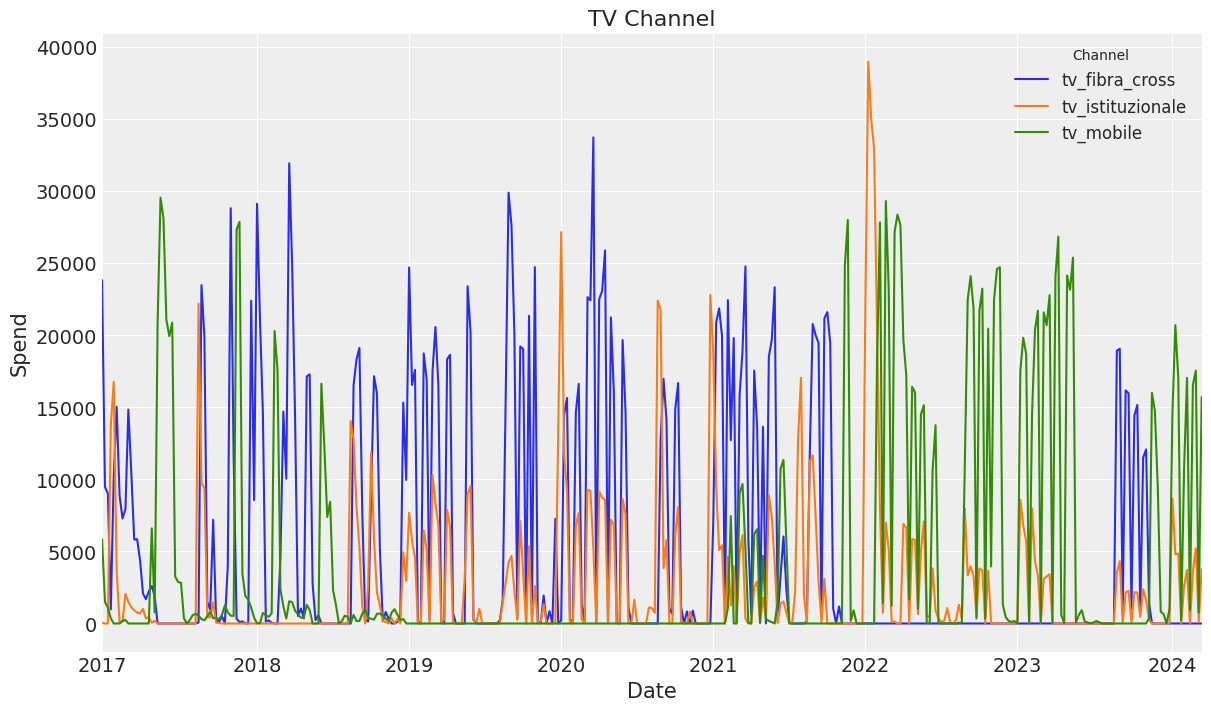

In [ ]:
fig, ax = plt.subplots()
df[tv_columns].plot(ax=ax)
ax.legend(title="Channel", fontsize=12)
ax.set(title="TV Channel", xlabel="Date", ylabel="Spend");

/tmp/ipykernel_11997/844654181.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


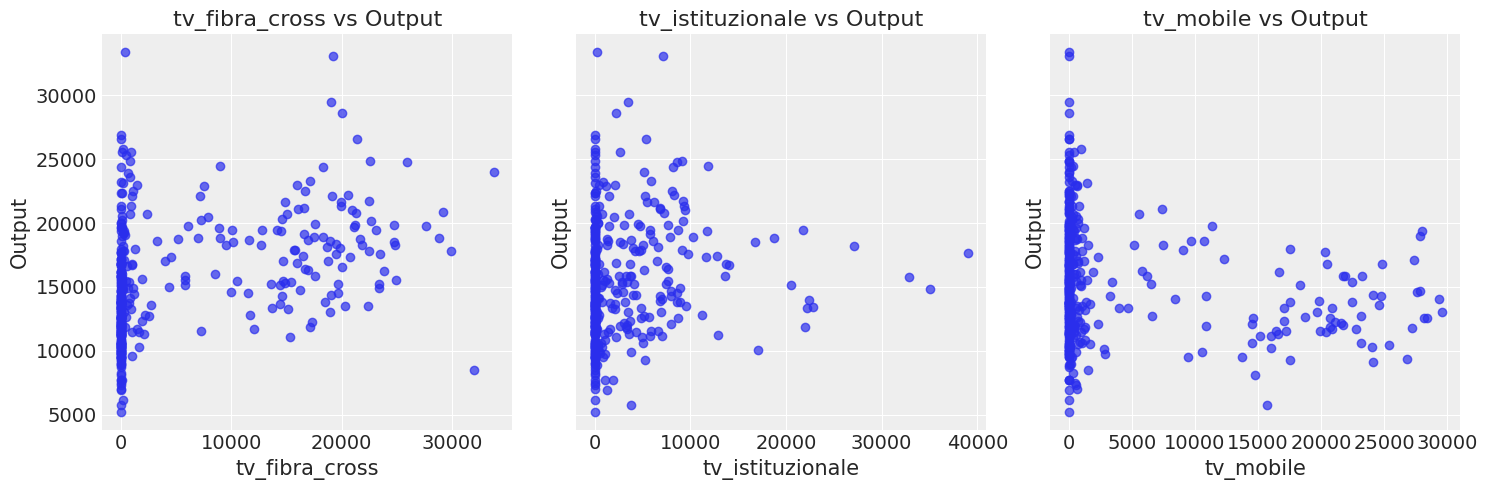

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

axes = axes.ravel()

for i, col in enumerate(tv_columns):
    axes[i].scatter(df[col], df['Output'], alpha=0.7)
    axes[i].set(title=f"{col} vs Output", xlabel=col, ylabel="Output")

plt.tight_layout()
plt.show()

tv fibra and tv mobile may have an impact on the output, the first in a positive way while the second in a negative way.

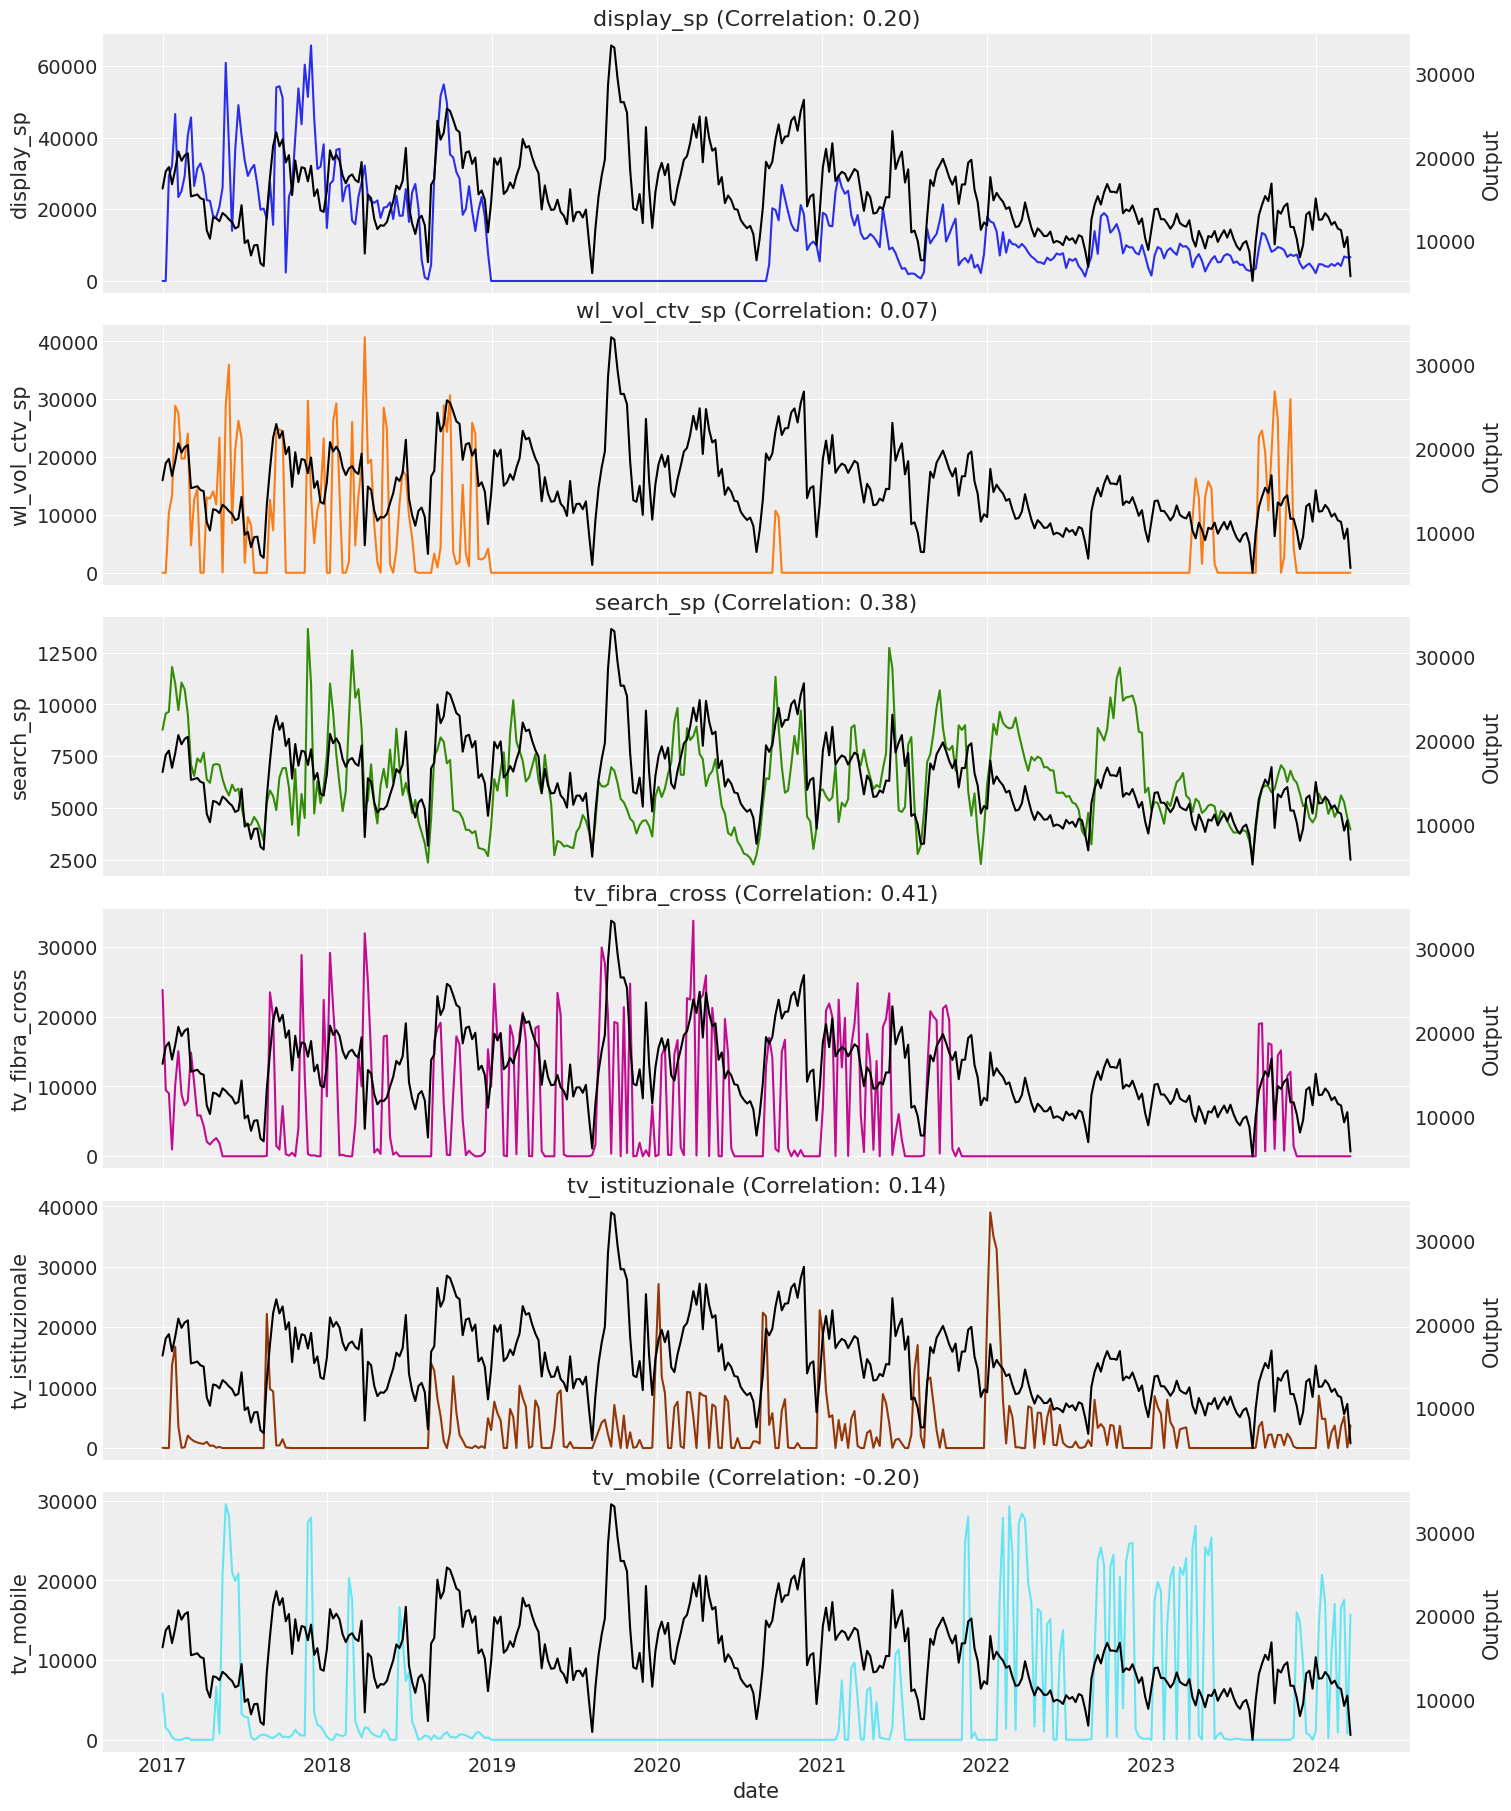

In [ ]:
n_channels = len(channel_columns)

fig, axes = plt.subplots(
    nrows=n_channels,
    ncols=1,
    figsize=(15, 3 * n_channels),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, channel in enumerate(channel_columns):
    ax = axes[i]
    ax_twin = ax.twinx()
    sns.lineplot(data=df, x=df.index, y=channel, color=f"C{i}", ax=ax)
    sns.lineplot(data=df, x=df.index, y=df['Output'], color="black", ax=ax_twin)
    correlation = df[[channel, 'Output']].corr().iloc[0, 1]
    ax_twin.grid(None)
    ax.set(title=f"{channel} (Correlation: {correlation:.2f})")

ax.set_xlabel("date");

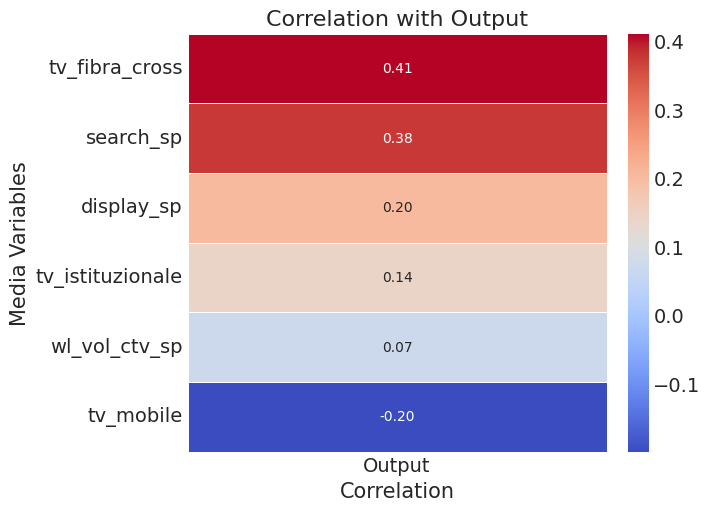

In [ ]:
correlations = df[channel_columns + ['Output']].corr()
correlation_with_output = correlations['Output'].drop('Output')
correlation_with_output = correlation_with_output.sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.heatmap(
    correlation_with_output.to_frame(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation with Output")
plt.ylabel("Media Variables")
plt.xlabel("Correlation")
plt.show()

Also the correlation with the output can be an indicator of the importance of the variable, even if we have to be cautious with collinearity in the model.

# Train - Test splitting

Test set is used to evaluate the final models, and not for training

In [ ]:
train_test_split_date = pd.to_datetime("2023-01-01")

train_mask = df.index < train_test_split_date
test_mask = df.index >= train_test_split_date

train_df = df[train_mask]
test_df = df[test_mask]

print(f"Proportions -> Training: {(len(train_df) / len(df)):.2%}, Test: {(len(test_df) / len(df)):.2%}")

Proportions -> Training: 83.02%, Test: 16.98%


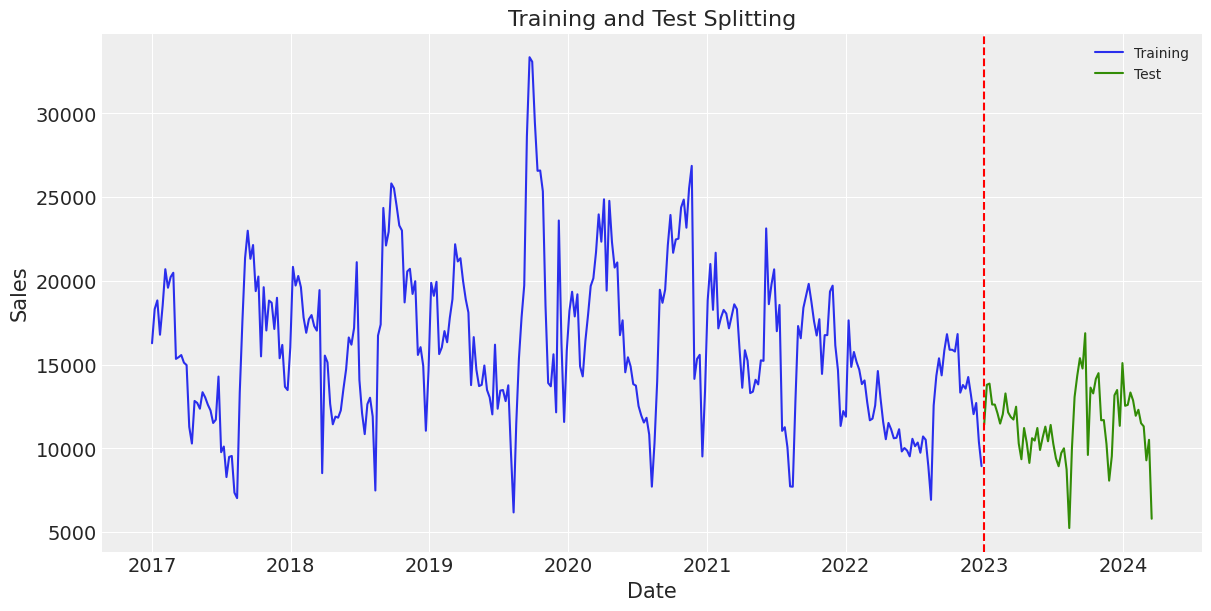

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=train_df, x="date_start_week", y="Output", color="C0", label="Training", ax=ax)
sns.lineplot(data=test_df, x="date_start_week", y="Output", color="C2", label="Test", ax=ax)

test_start_date = test_df.index[0]

ax.axvline(x=test_start_date, color="red", linestyle="--")

ax.set(title="Training and Test Splitting",
       xlabel="Date", ylabel="Sales")
ax.legend( fontsize=10)
plt.show()

# Range-aware Scaling

since the range in the spending variables (media and tv columns) is important, we can scale the variables with min and max that are not computed separately for each variable, but toghether for the 4 variables. this can be done since they have the same measure unit.
the other groups can be standardized in the regular way.
also the response has to be standardized

In [ ]:
# Normalizzazione su train_df
train_df_std = train_df.copy()
train_df_std[media_columns] = (train_df_std[media_columns] - train_df_std[media_columns].stack().min()) / \
                              (train_df_std[channel_columns].stack().max() - train_df_std[channel_columns].stack().min())
train_df_std[tv_columns] = (train_df_std[tv_columns] - train_df_std[tv_columns].stack().min()) / \
                           (train_df_std[tv_columns].stack().max() - train_df_std[tv_columns].stack().min())

train_df_std['Output'] = (train_df_std['Output'] - train_df_std['Output'].min()) / \
                         (train_df_std['Output'].max() - train_df_std['Output'].min())

# Normalizzazione su test_df utilizzando min e max di train_df
test_df_std = test_df.copy()
test_df_std[media_columns] = (test_df_std[media_columns] - train_df[media_columns].stack().min()) / \
                             (train_df[channel_columns].stack().max() - train_df[channel_columns].stack().min())
test_df_std[tv_columns] = (test_df_std[tv_columns] - train_df[tv_columns].stack().min()) / \
                          (train_df[tv_columns].stack().max() - train_df[tv_columns].stack().min())

test_df_std['Output'] = (test_df_std['Output'] - train_df['Output'].min()) / \
                        (train_df['Output'].max() - train_df['Output'].min())

# Normalizzazione per price_columns e competitors_columns su train_df
train_df_std[price_columns] = (train_df_std[price_columns] - train_df_std[price_columns].min()) / \
                              (train_df_std[price_columns].max() - train_df_std[price_columns].min())
train_df_std[competitors_columns] = (train_df_std[competitors_columns] - train_df_std[competitors_columns].min()) / \
                                    (train_df_std[competitors_columns].max() - train_df_std[competitors_columns].min())

# Normalizzazione per price_columns e competitors_columns su test_df utilizzando min e max di train_df
test_df_std[price_columns] = (test_df_std[price_columns] - train_df[price_columns].min()) / \
                             (train_df[price_columns].max() - train_df[price_columns].min())
test_df_std[competitors_columns] = (test_df_std[competitors_columns] - train_df[competitors_columns].min()) / \
                                   (train_df[competitors_columns].max() - train_df[competitors_columns].min())

# Priors identification - AdStock and Saturation functions

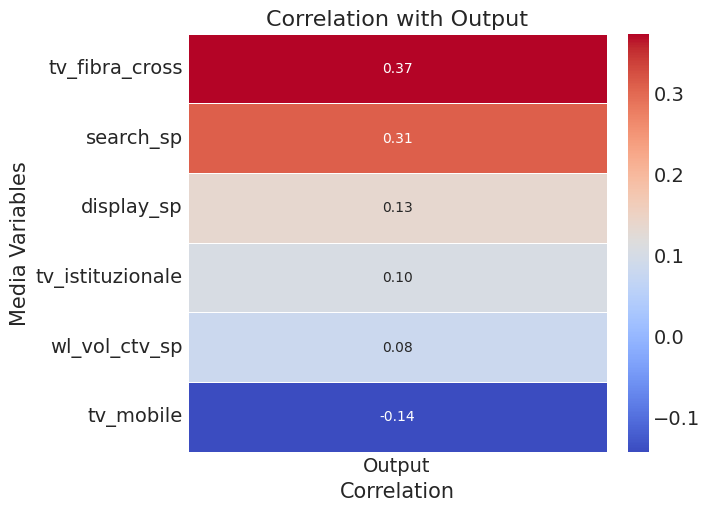

In [ ]:
correlations = train_df_std[channel_columns + ['Output']].corr()
correlation_with_output = correlations['Output'].drop('Output')
correlation_with_output = correlation_with_output.sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.heatmap(
    correlation_with_output.to_frame(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation with Output")
plt.ylabel("Media Variables")
plt.xlabel("Correlation")
plt.show()

/tmp/ipykernel_11997/2267423409.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


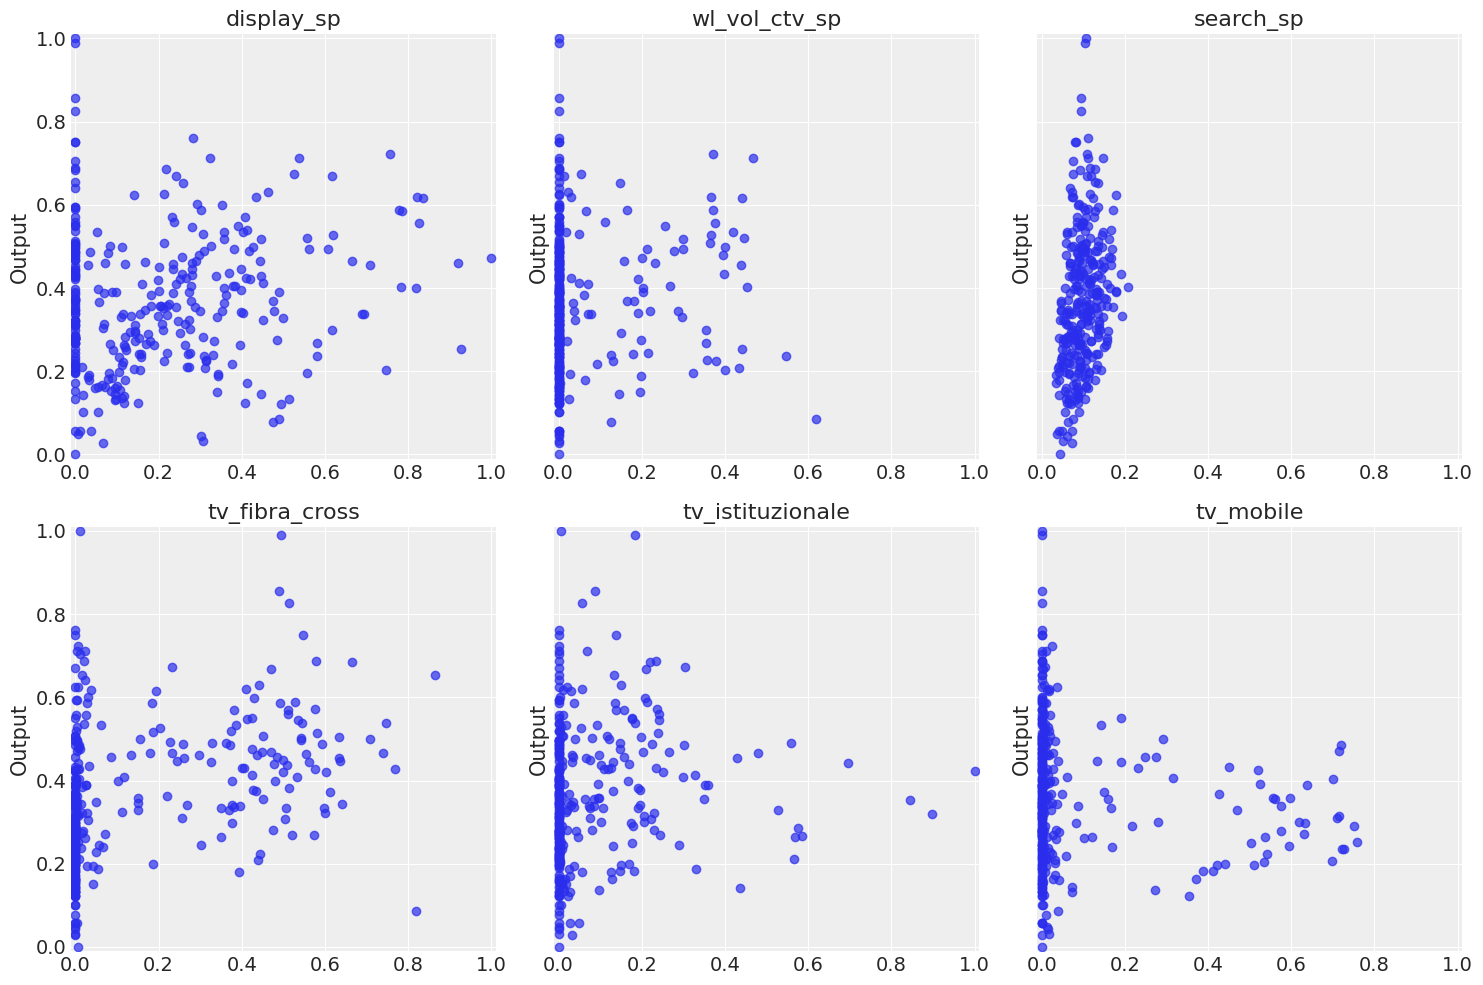

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,10), sharey=True)
axes = axes.ravel()

for i, col in enumerate(channel_columns):
    axes[i].scatter(train_df_std[col], train_df_std['Output'], alpha=0.7)
    axes[i].set(title=f"{col}", ylabel="Output")

common_limits = [-0.01, 1.01]
for ax in axes:
    ax.set_xlim(common_limits)
    ax.set_ylim(common_limits)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

plot of the transformed variables to choose the order to apply the functions and the hyperparameters priors

what we are looking for is a linear trend, that can be explainable by the model, linear in the transformed variables

and we want to increase (or at least keep unchanged) the correlation between variable and output

In [ ]:
# Logistic Saturation
def logistic_saturation(x, lam):
    return (1 - np.exp(-lam * x)) / (1 + np.exp(-lam * x))

# Adstock with Geometric Decay
def adstock(x, theta, L=10):
    weights = np.array([theta ** l for l in range(L)]) #from x(t-9) to x(t)
    adstocked = np.convolve(x, weights, mode='full')[:len(x)] / weights.sum()
    return adstocked

In [ ]:
saturation_params = {
    'display_sp': 20,
    'wl_vol_ctv_sp': 5,
    'search_sp': 0.2,
    'tv_fibra_cross': 5,
    'tv_istituzionale': 2.5,
    'tv_mobile': 5
}

adstock_params = {
    'display_sp':0.2,
    'wl_vol_ctv_sp': 0.3,
    'search_sp': 0.3,
    'tv_fibra_cross': 0.8,
    'tv_istituzionale': 0.8,
    'tv_mobile': 0.8
}

# Trasformazioni
df_transformed = train_df_std.copy()

for col in media_columns:
    sat = logistic_saturation(df_transformed[col], lam=saturation_params[col])
    df_transformed[f'{col}_transformed'] = adstock(df_transformed[col], theta = adstock_params[col])

for col in tv_columns:
    ads = adstock(df_transformed[col], theta=adstock_params[col])
    df_transformed[f'{col}_transformed'] = logistic_saturation(ads, lam=saturation_params[col])

/tmp/ipykernel_11997/3113612413.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


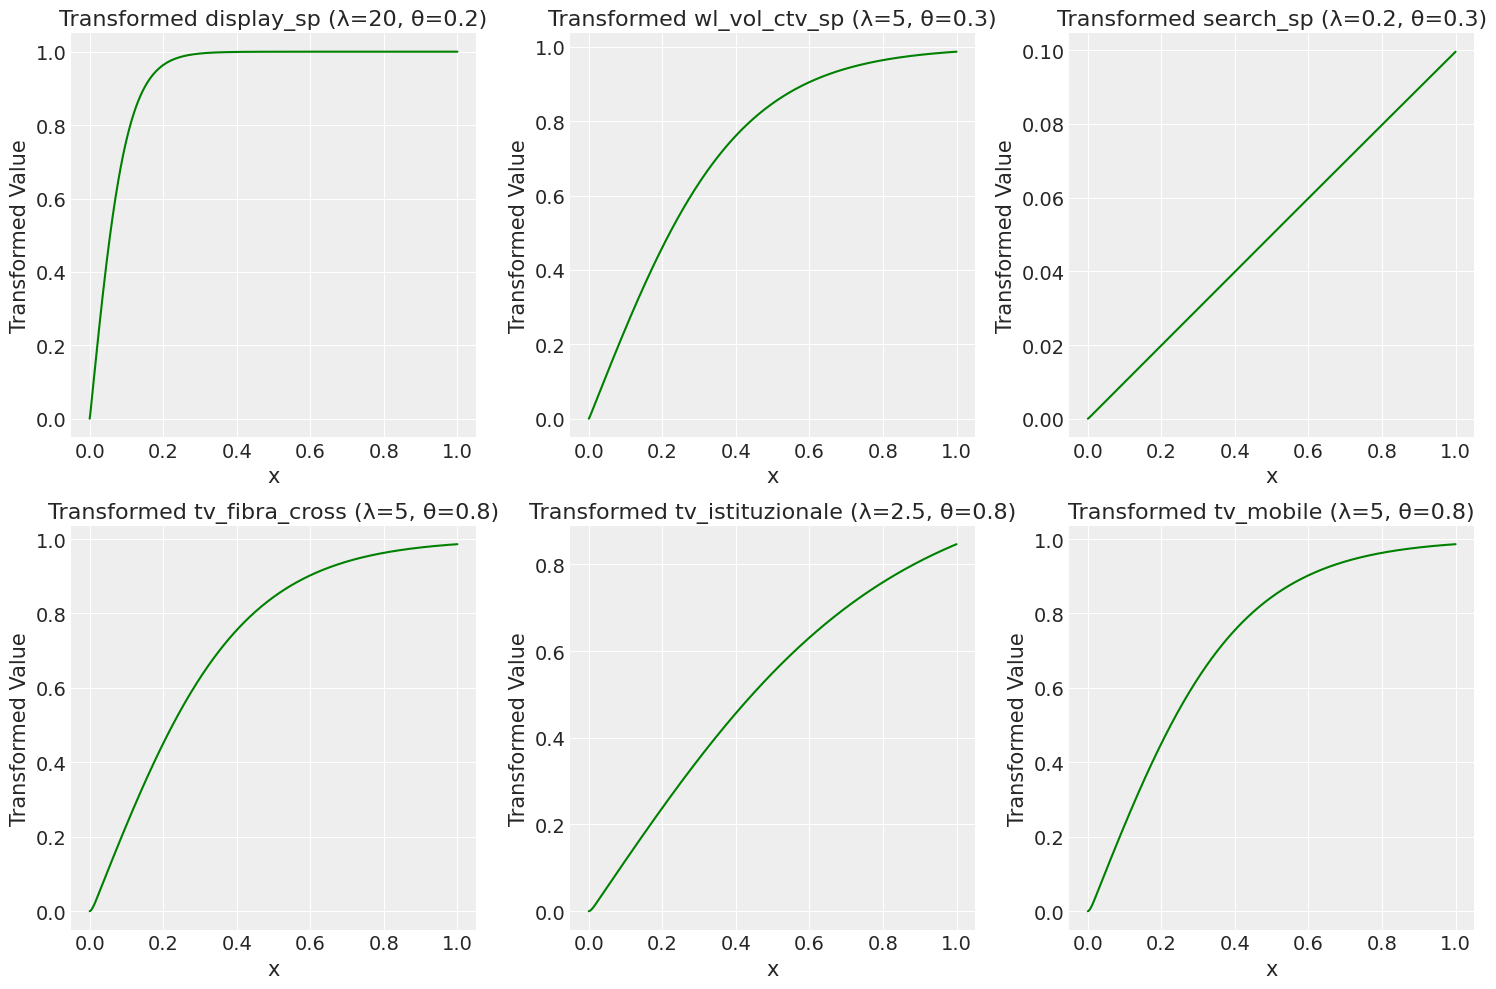

In [ ]:
x = np.linspace(0,1, 500)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, lam) in enumerate(saturation_params.items()):
    theta = adstock_params[name]

    if name in media_columns:
        sat_values = logistic_saturation(x, lam)
        transformed_values = adstock(sat_values, theta)
    elif name in tv_columns:
        ads_values = adstock(x, theta)
        transformed_values = logistic_saturation(ads_values, lam)

    axes[i].plot(x, transformed_values, color='green')
    axes[i].set_title(f"Transformed {name} (λ={lam}, θ={theta})")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("Transformed Value")
    axes[i].grid(True)

for j in range(len(saturation_params), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_11997/71941946.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


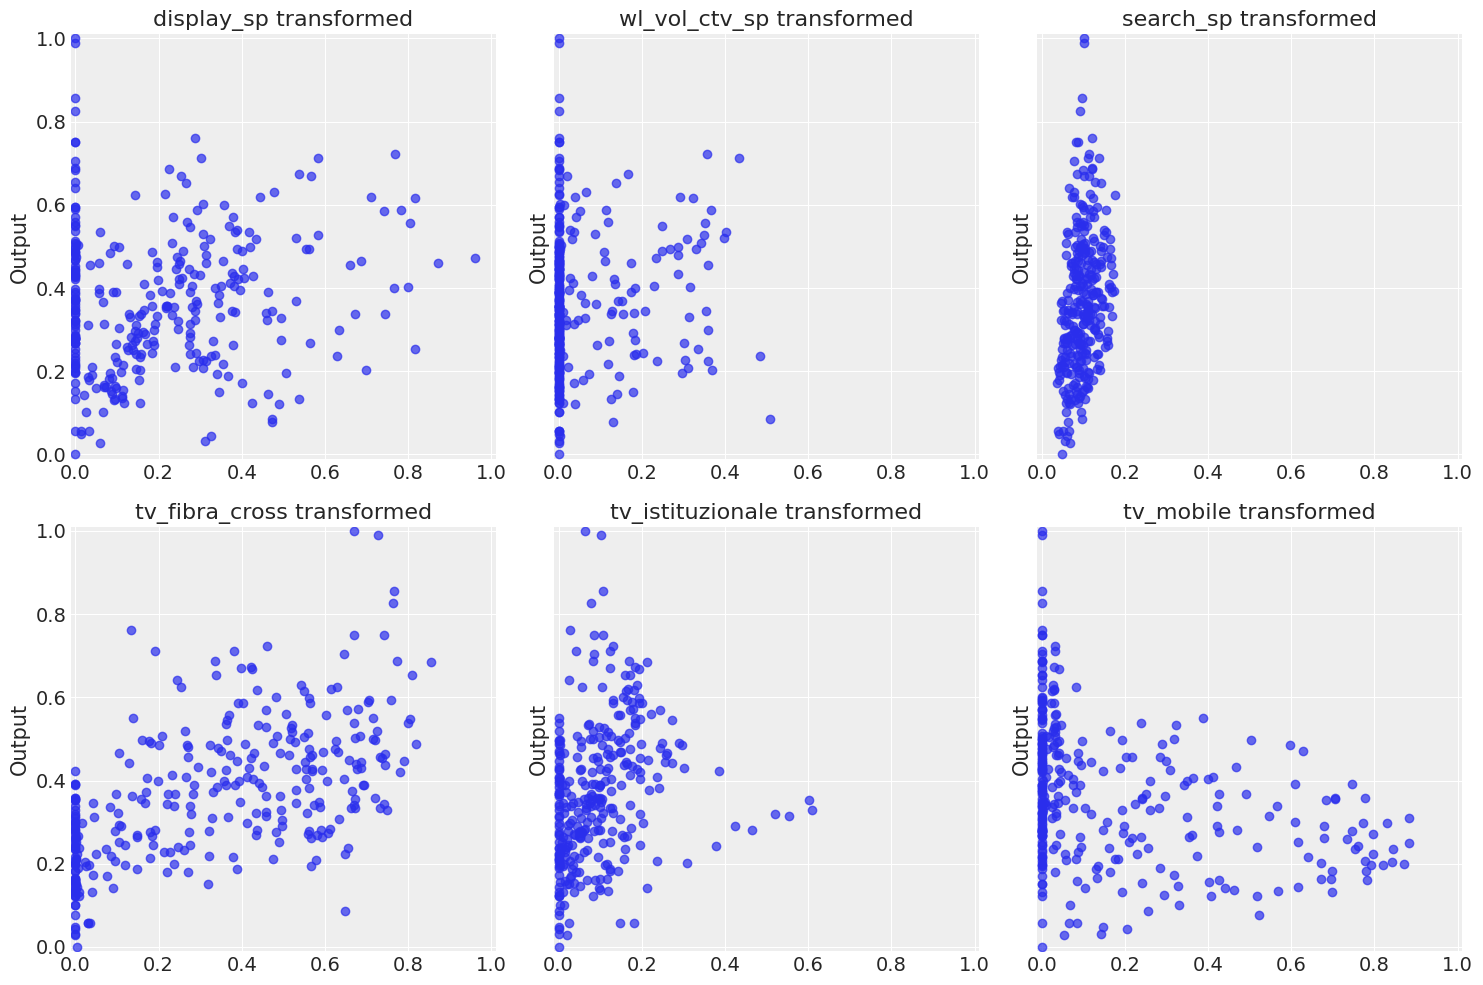

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,10), sharey=True)
axes = axes.ravel()

for i, col in enumerate(saturation_params.keys()):
    axes[i].scatter(df_transformed[f'{col}_transformed'], df_transformed['Output'], alpha=0.7)
    axes[i].set(title=f"{col} transformed", ylabel="Output")

for ax in axes:
    ax.set_xlim(common_limits)
    ax.set_ylim(common_limits)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

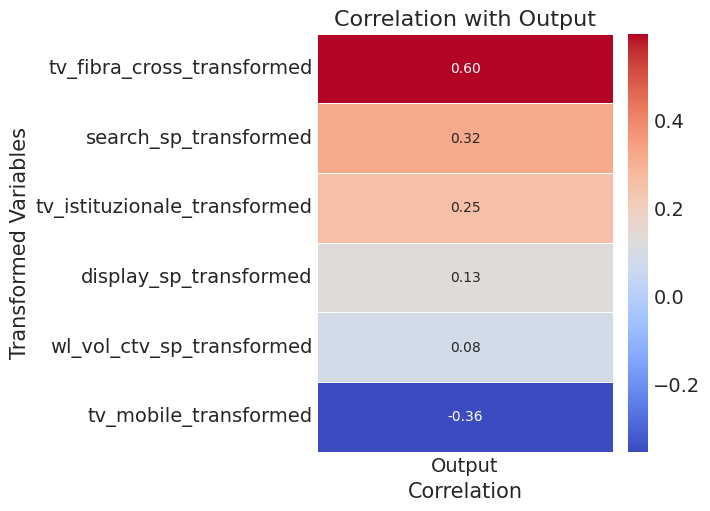

In [ ]:
transformed_columns = [f'{col}_transformed' for col in saturation_params.keys()]
correlations = df_transformed[transformed_columns + ['Output']].corr()
correlation_with_output = correlations['Output'].drop('Output')
correlation_with_output = correlation_with_output.sort_values(ascending=False)

plt.figure(figsize=(7,5))
sns.heatmap(
    correlation_with_output.to_frame(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar=True,
    linewidths=0.5
)
plt.title("Correlation with Output")
plt.ylabel("Transformed Variables")
plt.xlabel("Correlation")
plt.show()

correlations are amplified (except for display in which it's the same, trying with many different values) with the use of this functions. this means that they will be effective in the model

trying to apply adstock first and then saturation to tv variables improves their correlation with the output and understanding of nonlinear effects

# Only GP

In [ ]:
# initial group of variables that we'll use in the models
channel_columns = [ 'display_sp', 'wl_vol_ctv_sp', 'search_sp', 'tv_fibra_cross', 'tv_istituzionale', 'tv_mobile']
media_columns = [ 'display_sp', 'wl_vol_ctv_sp', 'search_sp'] #in case of different processing for media and tv variables
tv_columns=['tv_fibra_cross', 'tv_istituzionale', 'tv_mobile']

#CONTROL
control_columns = ['covid19', 'special_promo','ferragosto','christmas'] #without t, year and week number

#COMPETITORS
competitors_columns = ['tot_tv_comp_fibra','tot_tv_comp_mobile','tot_tv_comp_istituzionale','tv_comp1_mobile']

#PRICE
price_columns = ['web_prezzo_ottico','max_delta_store_comp','max_delta_web_comp','delta_web_comp1' ,'delta_store_comp1' ]

In [ ]:
#redefine non linear functions using pm operations
def logistic_saturation_pm(x, lam):
    return (1 - pm.math.exp(-lam * x)) / (1 + pm.math.exp(-lam * x))

def adstock_pm(x, theta, L=10):
    weights = theta ** np.arange(L)
    weights /= pm.math.sum(weights)

    adstocked = 0
    for l in range(L):
        shifted_x = pm.math.concatenate([pm.math.zeros(l), x[:-l]]) if l > 0 else x
        adstocked += shifted_x * weights[l]

    return adstocked

In [ ]:
#if I want the priors for control and channel variables:
import statsmodels.api as sm

X = sm.add_constant(df_transformed[channel_columns+control_columns+price_columns+competitors_columns])
#X = sm.add_constant(df_transformed[channel_columns+control_columns])
y = df_transformed['Output']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Output   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     22.74
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           8.02e-47
Time:                        18:45:46   Log-Likelihood:                 254.81
No. Observations:                 313   AIC:                            -469.6
Df Residuals:                     293   BIC:                            -394.7
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
betas_control=model.params[1+ len(media_columns)+len(tv_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)]
betas_price=model.params[1+ len(media_columns)+len(tv_columns)+len(control_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns)]
interc_prior=model.params[0]

In [ ]:
sigma_media=0.08*np.ones(len(media_columns))
sigma_tv=0.08*np.ones(len(tv_columns))
sigma_control=0.1*np.ones(len(control_columns))
sigma_competitors=0.1*np.ones(len(competitors_columns))
sigma_price=0.1*np.ones(len(price_columns))
sigma_channels=np.concatenate([sigma_media,sigma_tv])

In [ ]:
control_columns_idx = [train_df_std.columns.get_loc(col) for col in control_columns]
price_columns_idx = [train_df_std.columns.get_loc(col) for col in price_columns]
competitors_columns_idx = [train_df_std.columns.get_loc(col) for col in competitors_columns]

In [ ]:
gp_length_scale=10

In [ ]:
with pm.Model() as model:

    # Input and Output Variable
    X = pm.Data("X", train_df_std)
    y = pm.Data("y", train_df_std["Output"].values)

    # Priors
    lambda_params = pm.Gamma("lambda_params", mu=np.array([param for param in saturation_params.values()]), sigma = 0.01 ,shape=len(saturation_params))
    theta_params = pm.Beta("theta_params", mu=np.array([param for param in adstock_params.values()]), sigma = 0.01, shape=len(adstock_params))

    # Channel Trasformations
    transformed_vars = {}
    for i, col in enumerate(channel_columns):
        x = X[:,i]
        if col in media_columns:
            x_transformed = logistic_saturation_pm(x, lam=lambda_params[i])
            x_transformed = adstock_pm(x_transformed, theta=theta_params[i])
        elif col in tv_columns:
            x_transformed = adstock_pm(x, theta=theta_params[i])
            x_transformed = logistic_saturation_pm(x_transformed, lam=lambda_params[i])
        transformed_vars[col] = x_transformed

    X_transformed = pm.math.stack(list(transformed_vars.values()), axis=1)

    # Coefficients
    betas_channel = pm.HalfNormal("betas_channel", sigma=sigma_channels)
    betas_competitors = pm.HalfNormal("betas_competitors", sigma=sigma_competitors)
    betas_price = pm.Normal("betas_price", mu=betas_price, sigma=sigma_price)
    betas_control = pm.Normal("betas_control", mu=betas_control, sigma=sigma_control)
    intercept = pm.HalfNormal("intercept", sigma=0.5)

    # GP
    kernel = pm.gp.cov.Periodic(ls=gp_length_scale, period=52, input_dim=1)
    gp = pm.gp.Latent(cov_func=kernel)
    f = gp.prior("f", X=train_df_std["week_number"].values[:, None])  # f dipende dal tempo

    # Linear Model
    channel=pm.math.dot(X_transformed,betas_channel)
    price=pm.math.dot(X[:,price_columns_idx],betas_price)
    control=pm.math.dot(X[:,control_columns_idx],betas_control)
    competitors=pm.math.dot(X[:,competitors_columns_idx],betas_competitors)
    mu = pm.Deterministic("mu",intercept+f*channel+price+control-competitors)

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

In [ ]:
with model:
    prior_predictive = pm.sample_prior_predictive()

Sampling: [betas_channel, betas_competitors, betas_control, betas_price, f_rotated_, intercept, lambda_params, sigma, theta_params, y_obs]


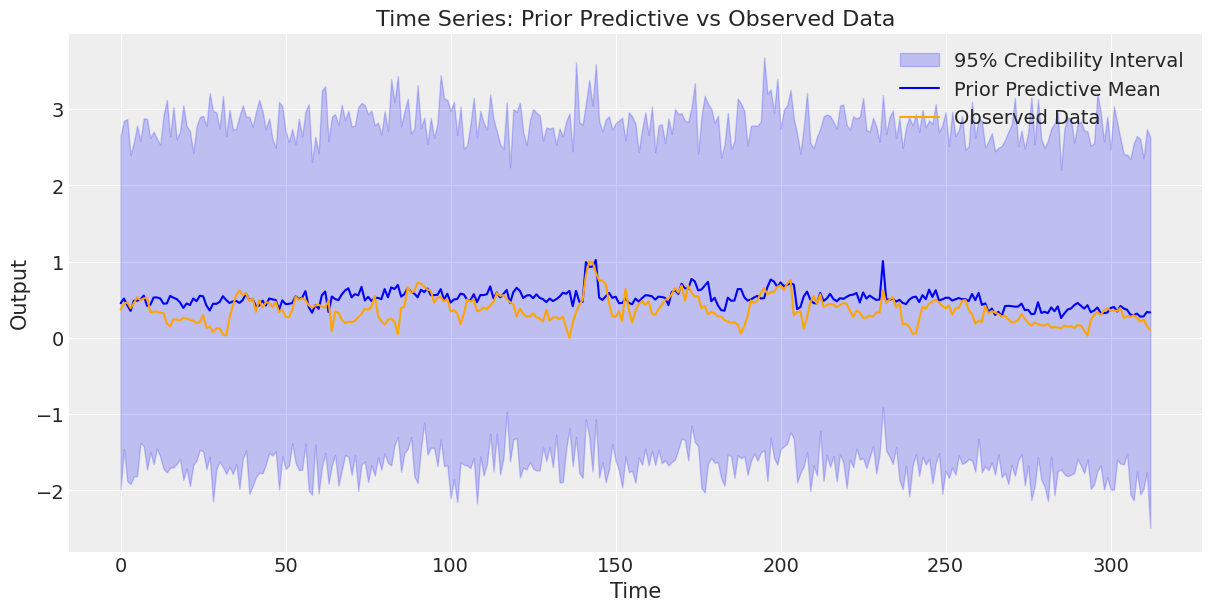

In [ ]:
y_prior = prior_predictive["prior_predictive"]["y_obs"].values

y_prior_mean = np.mean(y_prior, axis=(0, 1))
y_prior_lower = np.percentile(y_prior, 2.5, axis=(0, 1))
y_prior_upper = np.percentile(y_prior, 97.5, axis=(0, 1))

y_observed = train_df_std["Output"].values

plt.figure(figsize=(12, 6))
plt.fill_between(np.arange(len(y_observed)), y_prior_lower, y_prior_upper, color="blue", alpha=0.2, label="95% Credibility Interval")
plt.plot(np.arange(len(y_observed)), y_prior_mean, color="blue", label="Prior Predictive Mean")
plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.title("Time Series: Prior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

In [ ]:
with model:
    trace = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True, nuts_sampler='numpyro', chains=4,cores=4) #init="adapt_diag"

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)

Sampling: [y_obs]


Output()

In [ ]:
gp_posterior = trace.posterior['f']
gp_posterior_mean = gp_posterior.mean(dim=("chain", "draw")).values

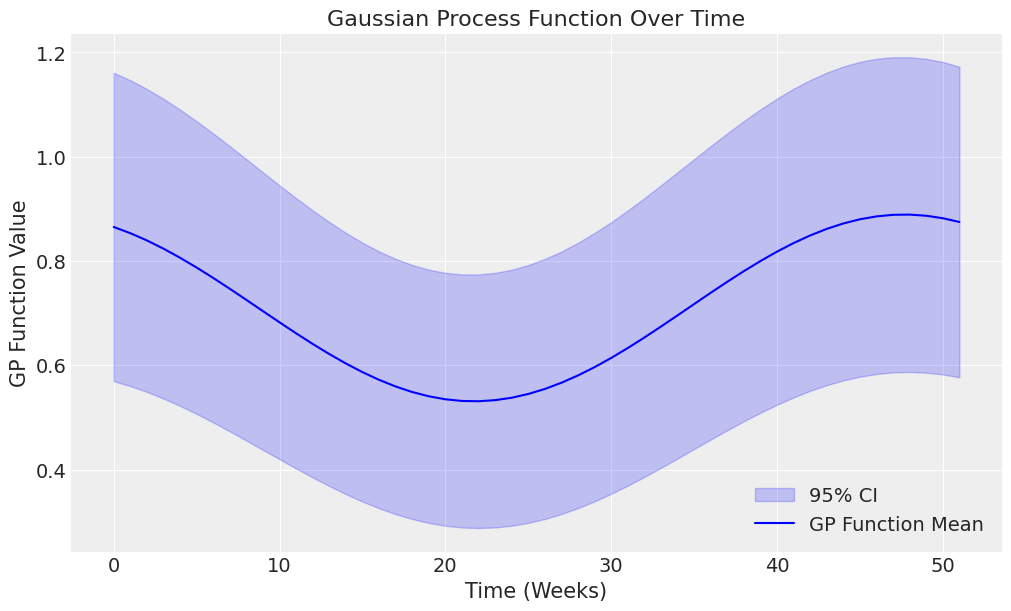

In [ ]:
f_posterior = trace.posterior['f']
f_posterior = f_posterior[:, :, :52]
time_range = np.arange(f_posterior.shape[2])
X_test = np.expand_dims(time_range, axis=1)

f_mean = np.mean(f_posterior, axis=(0, 1))
f_std = np.std(f_posterior, axis=(0, 1))

plt.figure(figsize=(10, 6))
plt.fill_between(time_range, f_mean - 1.96 * f_std, f_mean + 1.96 * f_std, color='blue', alpha=0.2, label='95% CI')
plt.plot(time_range, f_mean, color='blue', label='GP Function Mean')
plt.title("Gaussian Process Function Over Time")
plt.xlabel("Time (Weeks)")
plt.ylabel("GP Function Value")
plt.legend()
plt.show()

# Only Fourier

In [ ]:
# Genera un indice temporale
time_index = np.arange(len(train_df_std))  # Ad esempio, ogni riga è un'osservazione temporale

fourier_columns=[]
# Funzione per calcolare le basi di Fourier
def fourier_basis(time, period, order):
    bases = {}
    for k in range(1, order + 1):
        sin_col = f'sin_{k}'
        cos_col = f'cos_{k}'
        df_transformed[sin_col] = np.sin(2 * np.pi * k * time / period)
        df_transformed[cos_col] = np.cos(2 * np.pi * k * time / period)
        train_df_std[sin_col] = np.sin(2 * np.pi * k * time / period)
        train_df_std[cos_col] = np.cos(2 * np.pi * k * time / period)
        fourier_columns.append(sin_col)
        fourier_columns.append(cos_col)
    return pd.DataFrame(bases, index=time_index)  # Assegna gli indici per l'allineamento

n_basis = 3
fourier_basis(time_index, period=52, order=n_basis)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[313 rows x 0 columns]

In [ ]:
#if I want the priors for control and channel variables:
import statsmodels.api as sm

X = sm.add_constant(df_transformed[channel_columns+control_columns+price_columns+fourier_columns+competitors_columns])
#X = sm.add_constant(df_transformed[channel_columns+control_columns])
y = df_transformed['Output']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Output   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     30.64
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.97e-66
Time:                        18:50:48   Log-Likelihood:                 316.43
No. Observations:                 313   AIC:                            -580.9
Df Residuals:                     287   BIC:                            -483.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
betas_control=model.params[1+ len(media_columns)+len(tv_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)]
betas_price=model.params[1+ len(media_columns)+len(tv_columns)+len(control_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns)]
betas_fourier=model.params[1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns)+len(fourier_columns)]
interc_prior=model.params[0]

In [ ]:
sigma_media=0.08*np.ones(len(media_columns))
sigma_tv=0.08*np.ones(len(tv_columns))
sigma_control=0.1*np.ones(len(control_columns))
sigma_competitors=0.1*np.ones(len(competitors_columns))
sigma_price=0.1*np.ones(len(price_columns))
sigma_fourier=0.1*np.ones(len(fourier_columns))
sigma_channels=np.concatenate([sigma_media,sigma_tv])

In [ ]:
control_columns_idx = [train_df_std.columns.get_loc(col) for col in control_columns]
price_columns_idx = [train_df_std.columns.get_loc(col) for col in price_columns]
competitors_columns_idx = [train_df_std.columns.get_loc(col) for col in competitors_columns]
fourier_columns_idx = [train_df_std.columns.get_loc(col) for col in fourier_columns]

In [ ]:
with pm.Model() as model:

    # Input and Output Variable
    X = pm.Data("X", train_df_std)
    y = pm.Data("y", train_df_std["Output"].values)

    # Priors
    lambda_params = pm.Gamma("lambda_params", mu=np.array([param for param in saturation_params.values()]), sigma = 0.01 ,shape=len(saturation_params))
    theta_params = pm.Beta("theta_params", mu=np.array([param for param in adstock_params.values()]), sigma = 0.01, shape=len(adstock_params))

    # Channel Trasformations
    transformed_vars = {}
    for i, col in enumerate(channel_columns):
        x = X[:,i]
        if col in media_columns:
            x_transformed = logistic_saturation_pm(x, lam=lambda_params[i])
            x_transformed = adstock_pm(x_transformed, theta=theta_params[i])
        elif col in tv_columns:
            x_transformed = adstock_pm(x, theta=theta_params[i])
            x_transformed = logistic_saturation_pm(x_transformed, lam=lambda_params[i])
        transformed_vars[col] = x_transformed

    X_transformed = pm.math.stack(list(transformed_vars.values()), axis=1)

    # Coefficients
    betas_channel = pm.HalfNormal("betas_channel", sigma=sigma_channels)
    betas_competitors = pm.HalfNormal("betas_competitors", sigma=sigma_competitors)
    betas_price = pm.Normal("betas_price", mu=betas_price, sigma=sigma_price)
    betas_control = pm.Normal("betas_control", mu=betas_control, sigma=sigma_control)
    betas_fourier = pm.Normal("betas_fourier", mu=betas_fourier, sigma=sigma_fourier)
    intercept = pm.HalfNormal("intercept", sigma=0.5)

    # Linear Model
    channel=pm.math.dot(X_transformed,betas_channel)
    price=pm.math.dot(X[:,price_columns_idx],betas_price)
    control=pm.math.dot(X[:,control_columns_idx],betas_control)
    competitors=pm.math.dot(X[:,competitors_columns_idx],betas_competitors)
    fourier=pm.math.dot(X[:,fourier_columns_idx],betas_fourier)
    mu = pm.Deterministic("mu",intercept+channel+price+control-competitors+fourier)

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

In [ ]:
with model:
    prior_predictive = pm.sample_prior_predictive()

Sampling: [betas_channel, betas_competitors, betas_control, betas_fourier, betas_price, intercept, lambda_params, sigma, theta_params, y_obs]


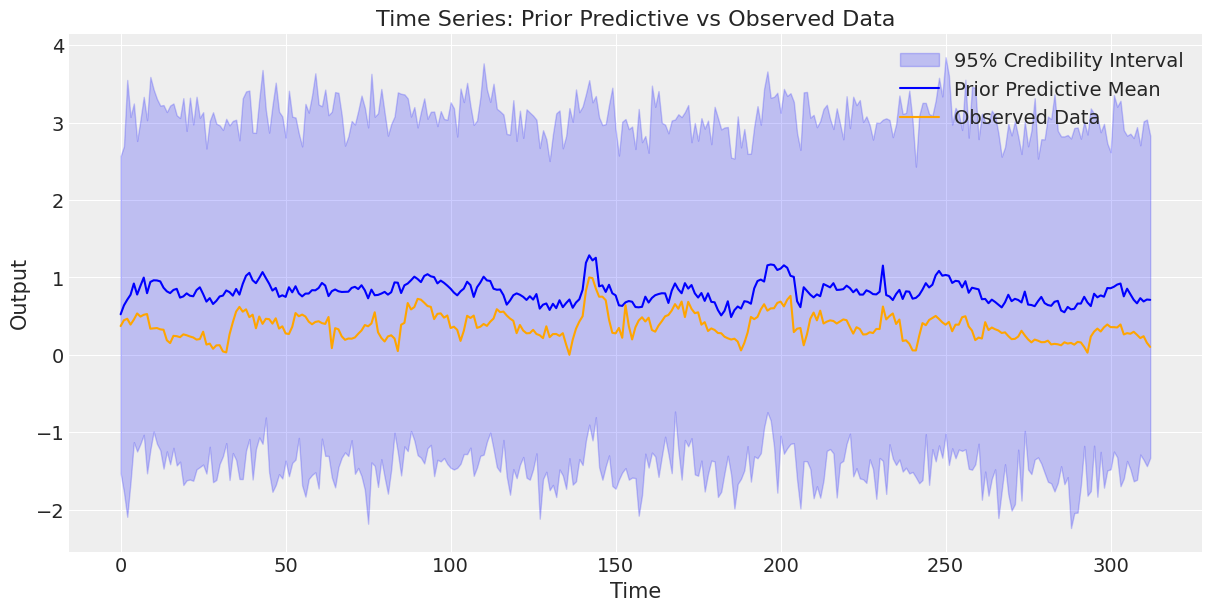

In [ ]:
y_prior = prior_predictive["prior_predictive"]["y_obs"].values

y_prior_mean = np.mean(y_prior, axis=(0, 1))
y_prior_lower = np.percentile(y_prior, 2.5, axis=(0, 1))
y_prior_upper = np.percentile(y_prior, 97.5, axis=(0, 1))

y_observed = train_df_std["Output"].values

plt.figure(figsize=(12, 6))
plt.fill_between(np.arange(len(y_observed)), y_prior_lower, y_prior_upper, color="blue", alpha=0.2, label="95% Credibility Interval")
plt.plot(np.arange(len(y_observed)), y_prior_mean, color="blue", label="Prior Predictive Mean")
plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.title("Time Series: Prior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

In [ ]:
with model:
    trace = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True, nuts_sampler='numpyro', chains=4,cores=4) #init="adapt_diag"

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)

Sampling: [y_obs]


Output()

In [ ]:
betas_fourier_mean = trace.posterior["betas_fourier"].mean(dim=["chain", "draw"]).values
fourier_contribution = np.dot(train_df_std[fourier_columns], betas_fourier_mean)

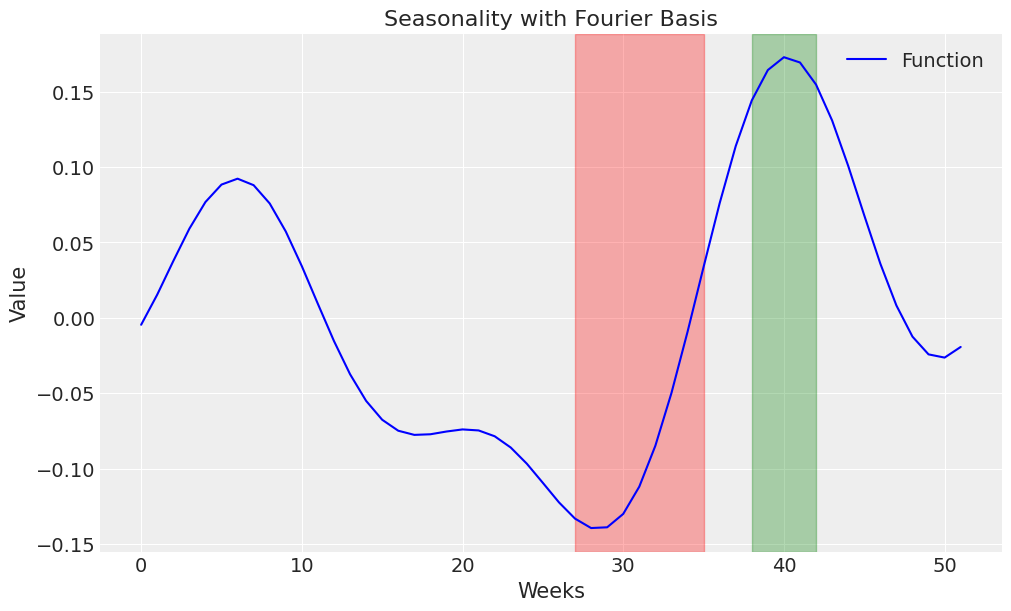

In [ ]:
time_index_year = time_index[:52]
# Plot della funzione ricostruita per un anno
plt.figure(figsize=(10, 6))
plt.plot(time_index_year, fourier_contribution[:52],  label='Function', color='blue')
plt.xlabel('Weeks')
plt.ylabel('Value')
plt.title('Seasonality with Fourier Basis')
plt.legend()
plt.grid(True)
plt.axvspan(27,35, color='red', alpha=0.3)
plt.axvspan(38,42, color='green', alpha=0.3)
plt.show()

# GP + Fourier

In [ ]:
#if I want the priors for control and channel variables:
import statsmodels.api as sm

X = sm.add_constant(df_transformed[channel_columns+control_columns+price_columns+fourier_columns+competitors_columns])
#X = sm.add_constant(df_transformed[channel_columns+control_columns])
y = df_transformed['Output']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Output   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     30.64
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.97e-66
Time:                        18:53:41   Log-Likelihood:                 316.43
No. Observations:                 313   AIC:                            -580.9
Df Residuals:                     287   BIC:                            -483.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
betas_control=model.params[1+ len(media_columns)+len(tv_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)]
betas_price=model.params[1+ len(media_columns)+len(tv_columns)+len(control_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns)]
betas_fourier=model.params[1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns):1+ len(media_columns)+len(tv_columns)+len(control_columns)+len(price_columns)+len(fourier_columns)]
interc_prior=model.params[0]

In [ ]:
betas_fourier=0.5*betas_fourier_mean

In [ ]:
sigma_media=0.08*np.ones(len(media_columns))
sigma_tv=0.08*np.ones(len(tv_columns))
sigma_control=0.1*np.ones(len(control_columns))
sigma_competitors=0.1*np.ones(len(competitors_columns))
sigma_price=0.1*np.ones(len(price_columns))
sigma_fourier=0.001*np.ones(len(fourier_columns))
sigma_channels=np.concatenate([sigma_media,sigma_tv])

In [ ]:
class MeanPrecomputed(pm.gp.mean.Mean):
    def __init__(self, f_mean):
        self.f_mean = f_mean  # Salva la media pre-calcolata

    def __call__(self, X):
        return self.f_mean  # Restituisce il valore di f_mean per gli input dati

with pm.Model() as model:
    # Input e output
    X = pm.Data("X", train_df_std)
    y = pm.Data("y", train_df_std["Output"].values)

    # Priors
    lambda_params = pm.Gamma("lambda_params", mu=np.array([param for param in saturation_params.values()]), sigma=0.01, shape=len(saturation_params))
    theta_params = pm.Beta("theta_params", mu=np.array([param for param in adstock_params.values()]), sigma=0.01, shape=len(adstock_params))

    # Channel Transformations
    transformed_vars = {}
    for i, col in enumerate(channel_columns):
        x = X[:, i]
        if col in media_columns:
            x_transformed = logistic_saturation_pm(x, lam=lambda_params[i])
            x_transformed = adstock_pm(x_transformed, theta=theta_params[i])
        elif col in tv_columns:
            x_transformed = adstock_pm(x, theta=theta_params[i])
            x_transformed = logistic_saturation_pm(x_transformed, lam=lambda_params[i])
        transformed_vars[col] = x_transformed

    X_transformed = pm.math.stack(list(transformed_vars.values()), axis=1)

    # Coefficienti
    betas_channel = pm.HalfNormal("betas_channel", sigma=sigma_channels)
    betas_competitors = pm.HalfNormal("betas_competitors", sigma=sigma_competitors)
    betas_price = pm.Normal("betas_price", mu=betas_price, sigma=sigma_price)
    betas_control = pm.Normal("betas_control", mu=betas_control, sigma=sigma_control)
    betas_fourier = pm.Normal("betas_fourier", mu=betas_fourier, sigma=sigma_fourier)
    intercept = pm.HalfNormal("intercept", sigma=0.5)

    # GP con media a priori data da f_mean
    f_mean_shared = pm.Data("f_mean_shared", 0.5*gp_posterior_mean)  # usa come prior la posterior dell'altro modello
    kernel = 0.01*pm.gp.cov.Periodic(ls=gp_length_scale, period=52, input_dim=1)  # kernel più stretto
    mean_func = MeanPrecomputed(f_mean_shared)
    gp = pm.gp.Latent(cov_func=kernel, mean_func=mean_func)
    f = gp.prior("f", X=train_df_std["week_number"].values[:, None])

    # Modello lineare
    channel = pm.math.dot(X_transformed, betas_channel)
    price = pm.math.dot(X[:, price_columns_idx], betas_price)
    control = pm.math.dot(X[:, control_columns_idx], betas_control)
    competitors = pm.math.dot(X[:, competitors_columns_idx], betas_competitors)
    fourier = pm.math.dot(X[:, fourier_columns_idx], betas_fourier)

    # La media mu ora include il nuovo GP
    mu = pm.Deterministic("mu", intercept + f*channel + price + control - competitors + fourier)

    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)


In [ ]:
with model:
    prior_predictive = pm.sample_prior_predictive()

Sampling: [betas_channel, betas_competitors, betas_control, betas_fourier, betas_price, f_rotated_, intercept, lambda_params, sigma, theta_params, y_obs]


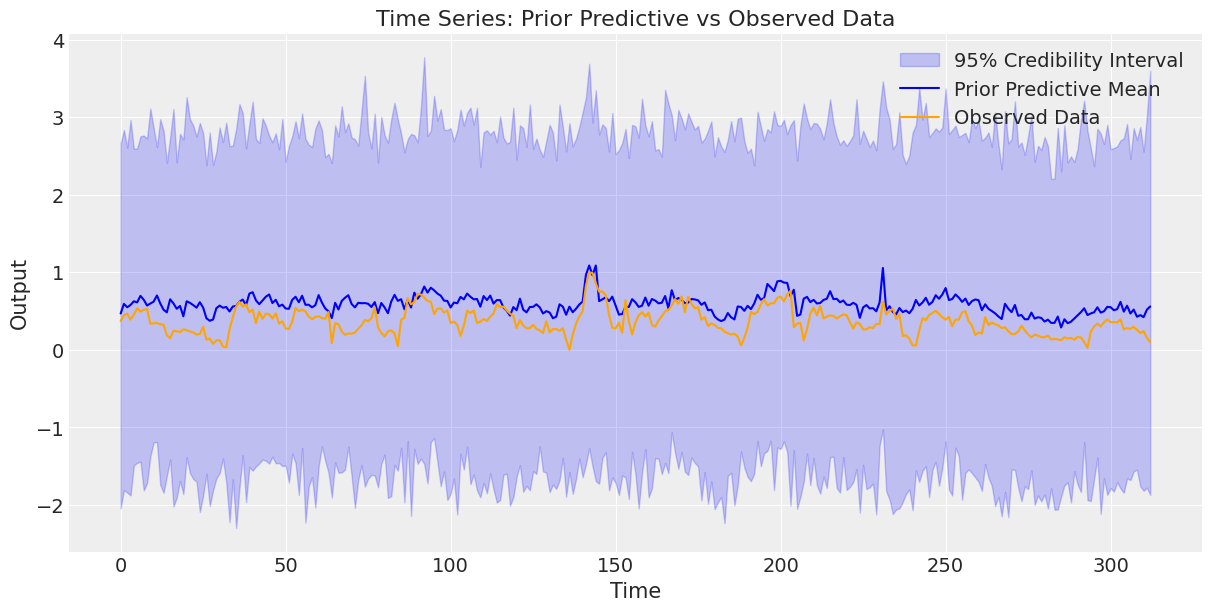

In [ ]:
y_prior = prior_predictive["prior_predictive"]["y_obs"].values

y_prior_mean = np.mean(y_prior, axis=(0, 1))
y_prior_lower = np.percentile(y_prior, 2.5, axis=(0, 1))
y_prior_upper = np.percentile(y_prior, 97.5, axis=(0, 1))

y_observed = train_df_std["Output"].values

plt.figure(figsize=(12, 6))
plt.fill_between(np.arange(len(y_observed)), y_prior_lower, y_prior_upper, color="blue", alpha=0.2, label="95% Credibility Interval")
plt.plot(np.arange(len(y_observed)), y_prior_mean, color="blue", label="Prior Predictive Mean")
plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.title("Time Series: Prior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

### Sampling and Diagnostic

In [ ]:
with model:
    trace = pm.sample(3000, tune=3000, target_accept=0.995, return_inferencedata=True, nuts_sampler='numpyro', chains=4,cores=4) #init="adapt_diag"

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)

Sampling: [y_obs]


Output()

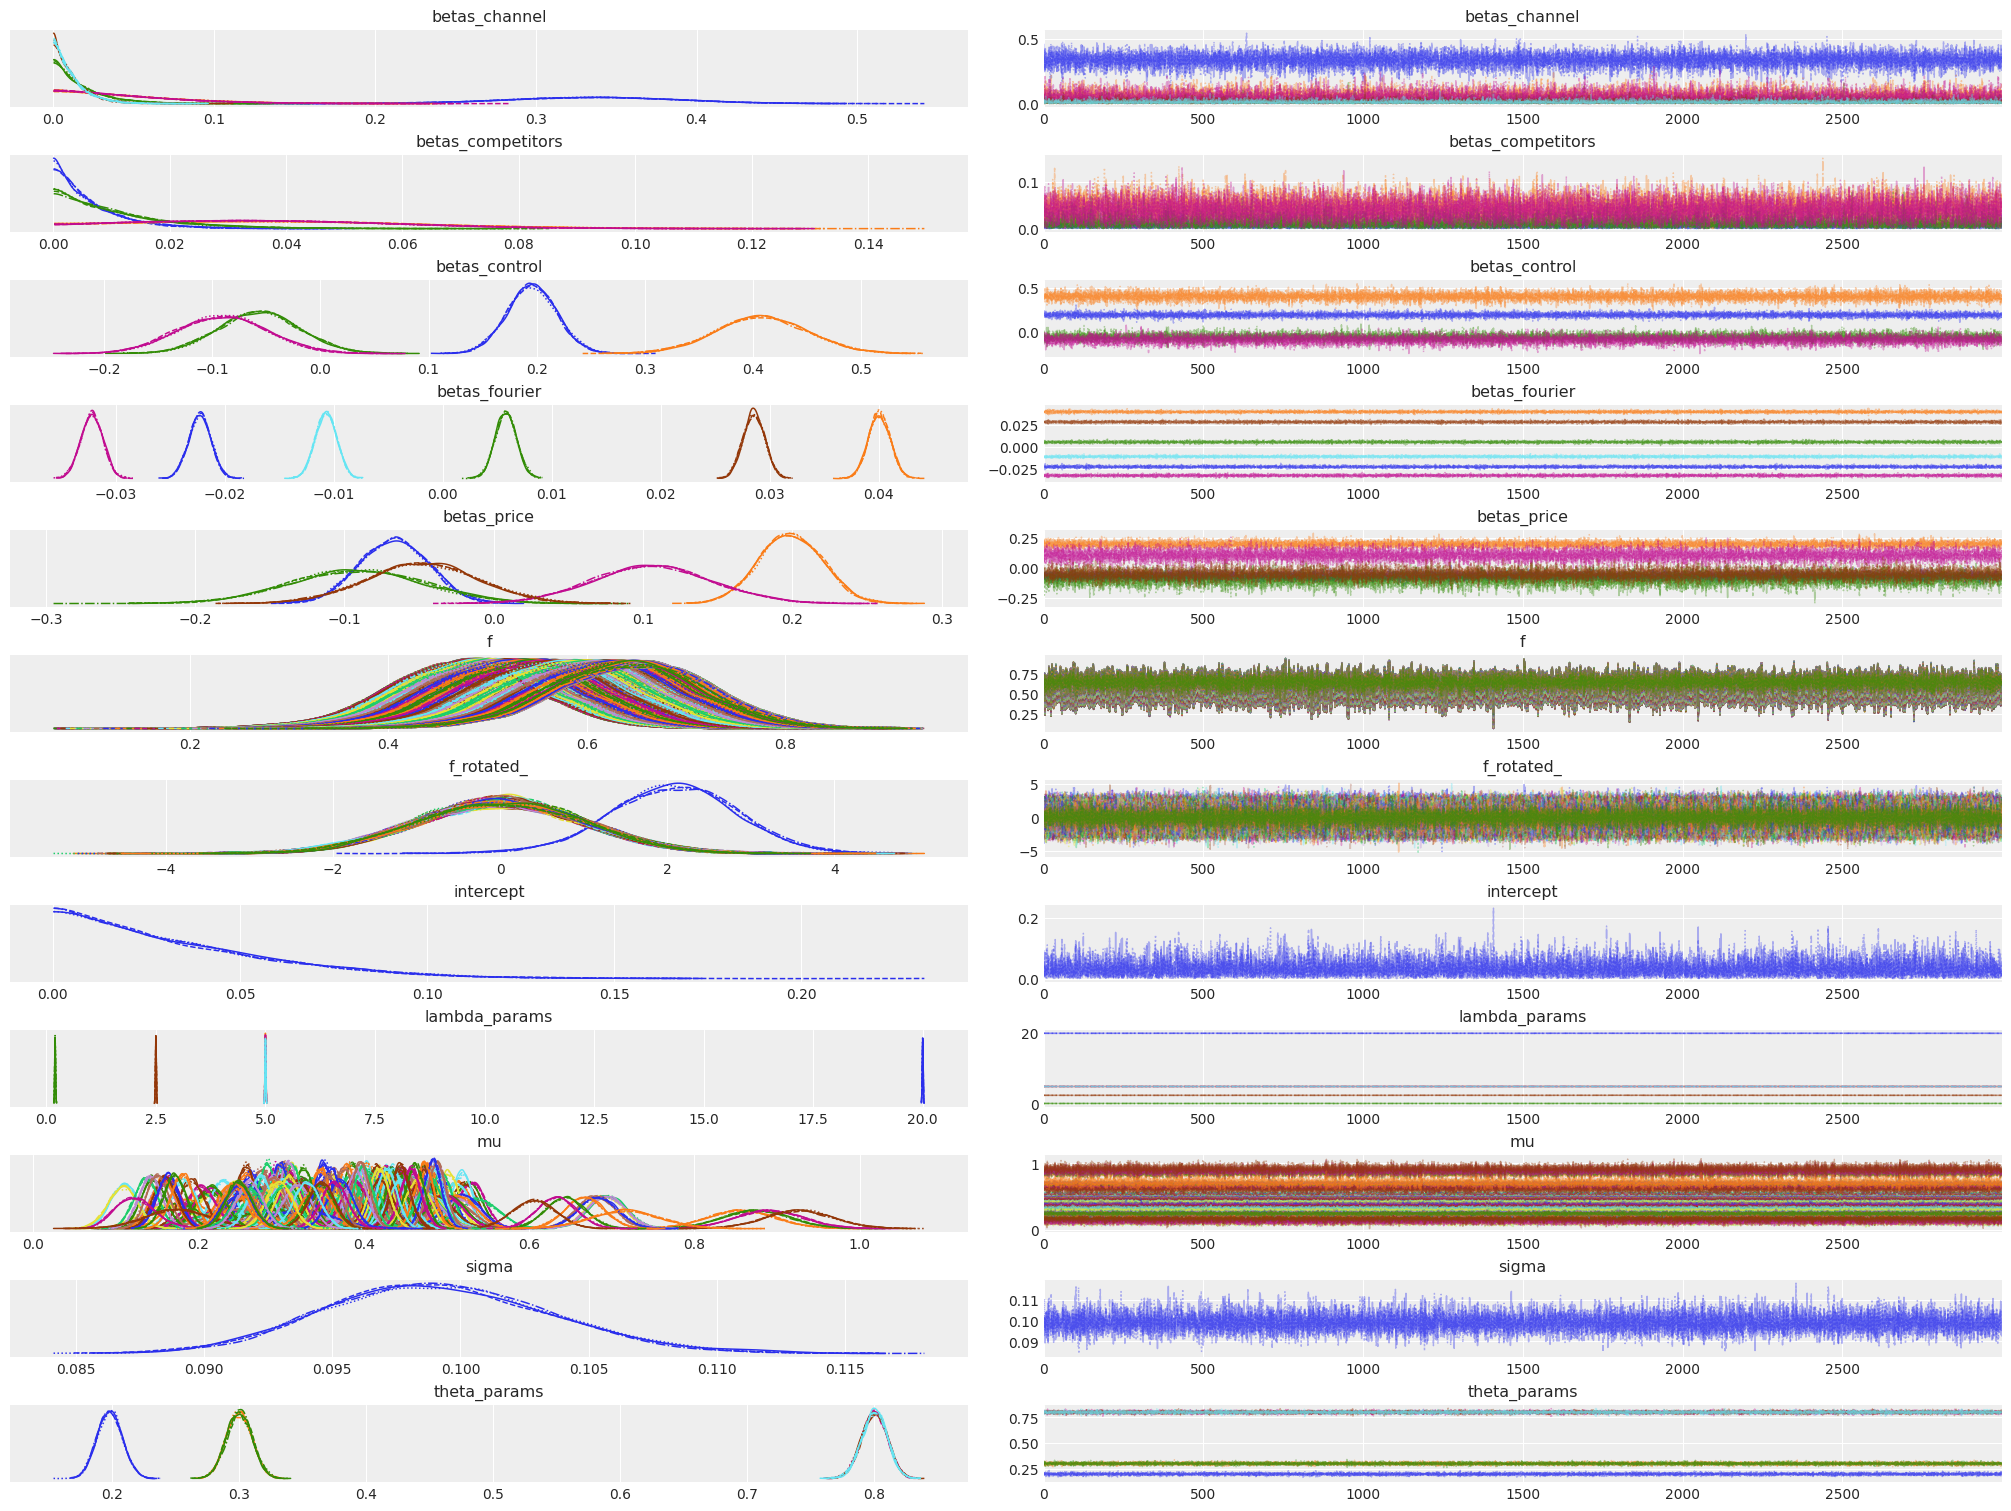

In [ ]:
az.plot_trace(trace, figsize=(20, 15))
plt.show()

In [ ]:
rhat_values = np.round(az.rhat(trace),2)
print("R-hat values:")
print(rhat_values)

R-hat values:
<xarray.Dataset> Size: 16kB
Dimensions:                  (betas_channel_dim_0: 6,
                              betas_competitors_dim_0: 4,
                              betas_control_dim_0: 4, betas_fourier_dim_0: 6,
                              betas_price_dim_0: 5, f_dim_0: 313,
                              f_rotated__dim_0: 313, lambda_params_dim_0: 6,
                              mu_dim_0: 313, theta_params_dim_0: 6)
Coordinates:
  * betas_channel_dim_0      (betas_channel_dim_0) int64 48B 0 1 2 3 4 5
  * betas_competitors_dim_0  (betas_competitors_dim_0) int64 32B 0 1 2 3
  * betas_control_dim_0      (betas_control_dim_0) int64 32B 0 1 2 3
  * betas_fourier_dim_0      (betas_fourier_dim_0) int64 48B 0 1 2 3 4 5
  * betas_price_dim_0        (betas_price_dim_0) int64 40B 0 1 2 3 4
  * f_dim_0                  (f_dim_0) int64 3kB 0 1 2 3 4 ... 309 310 311 312
  * f_rotated__dim_0         (f_rotated__dim_0) int64 3kB 0 1 2 ... 310 311 312
  * lambda_params_dim_0     

In [ ]:
np.any(rhat_values>1.01)

<xarray.Dataset> Size: 12B
Dimensions:            ()
Data variables:
    betas_channel      bool 1B False
    betas_competitors  bool 1B False
    betas_control      bool 1B False
    betas_fourier      bool 1B False
    betas_price        bool 1B False
    f                  bool 1B False
    f_rotated_         bool 1B False
    intercept          bool 1B False
    lambda_params      bool 1B False
    mu                 bool 1B False
    sigma              bool 1B False
    theta_params       bool 1B False

In [ ]:
np.any(rhat_values<1)

<xarray.Dataset> Size: 12B
Dimensions:            ()
Data variables:
    betas_channel      bool 1B False
    betas_competitors  bool 1B False
    betas_control      bool 1B False
    betas_fourier      bool 1B False
    betas_price        bool 1B False
    f                  bool 1B False
    f_rotated_         bool 1B False
    intercept          bool 1B False
    lambda_params      bool 1B False
    mu                 bool 1B False
    sigma              bool 1B False
    theta_params       bool 1B False

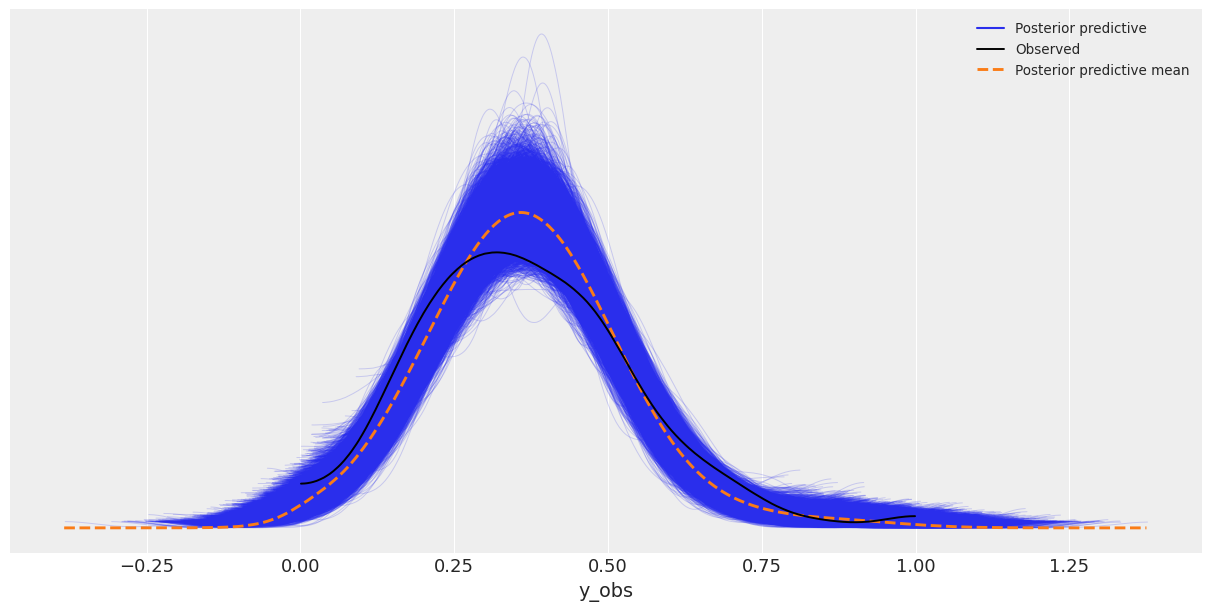

In [ ]:
az.plot_ppc(posterior_predictive, figsize=(12, 6), kind="kde")
plt.show()

### GP

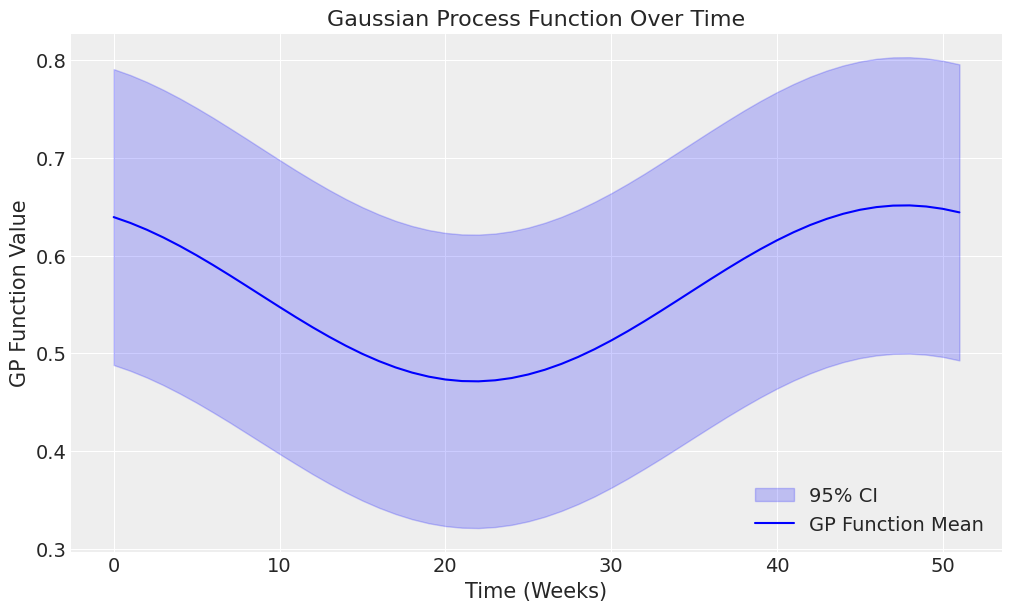

In [ ]:
f_posterior = trace.posterior['f']
f_posterior = f_posterior[:, :, :52]
time_range = np.arange(f_posterior.shape[2])
X_test = np.expand_dims(time_range, axis=1)

f_mean = np.mean(f_posterior, axis=(0, 1))
f_std = np.std(f_posterior, axis=(0, 1))

plt.figure(figsize=(10, 6))
plt.fill_between(time_range, f_mean - 1.96 * f_std, f_mean + 1.96 * f_std, color='blue', alpha=0.2, label='95% CI')
plt.plot(time_range, f_mean, color='blue', label='GP Function Mean')
plt.title("Gaussian Process Function Over Time")
plt.xlabel("Time (Weeks)")
plt.ylabel("GP Function Value")
plt.legend()
plt.show()

### Posterior Predictive

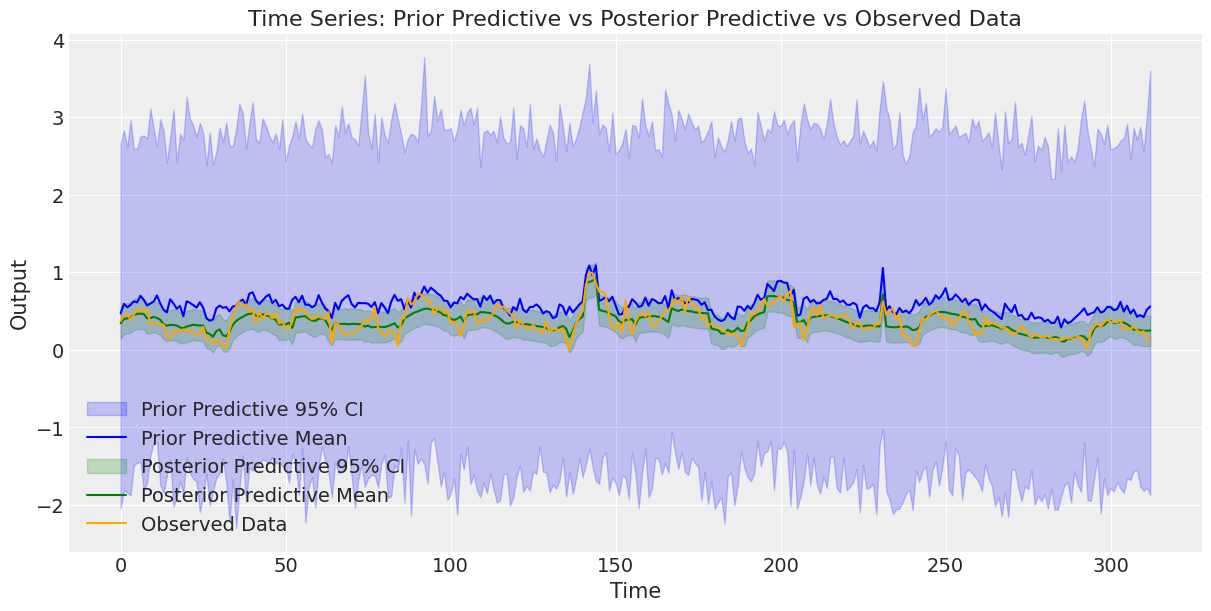

In [ ]:
y_train_posterior = posterior_predictive["posterior_predictive"]["y_obs"].values
y_train_posterior_mean = np.mean(y_train_posterior, axis=(0, 1))
y_train_posterior_lower = np.percentile(y_train_posterior, 2.5, axis=(0, 1))
y_train_posterior_upper = np.percentile(y_train_posterior, 97.5, axis=(0, 1))

plt.figure(figsize=(12, 6))
plt.fill_between(np.arange(len(y_observed)), y_prior_lower, y_prior_upper, color="blue", alpha=0.2, label="Prior Predictive 95% CI")
plt.plot(np.arange(len(y_observed)), y_prior_mean, color="blue", label="Prior Predictive Mean")
plt.fill_between(np.arange(len(y_observed)), y_train_posterior_lower, y_train_posterior_upper, color="green", alpha=0.2, label="Posterior Predictive 95% CI")
plt.plot(np.arange(len(y_observed)), y_train_posterior_mean, color="green", label="Posterior Predictive Mean")

plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.title("Time Series: Prior Predictive vs Posterior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

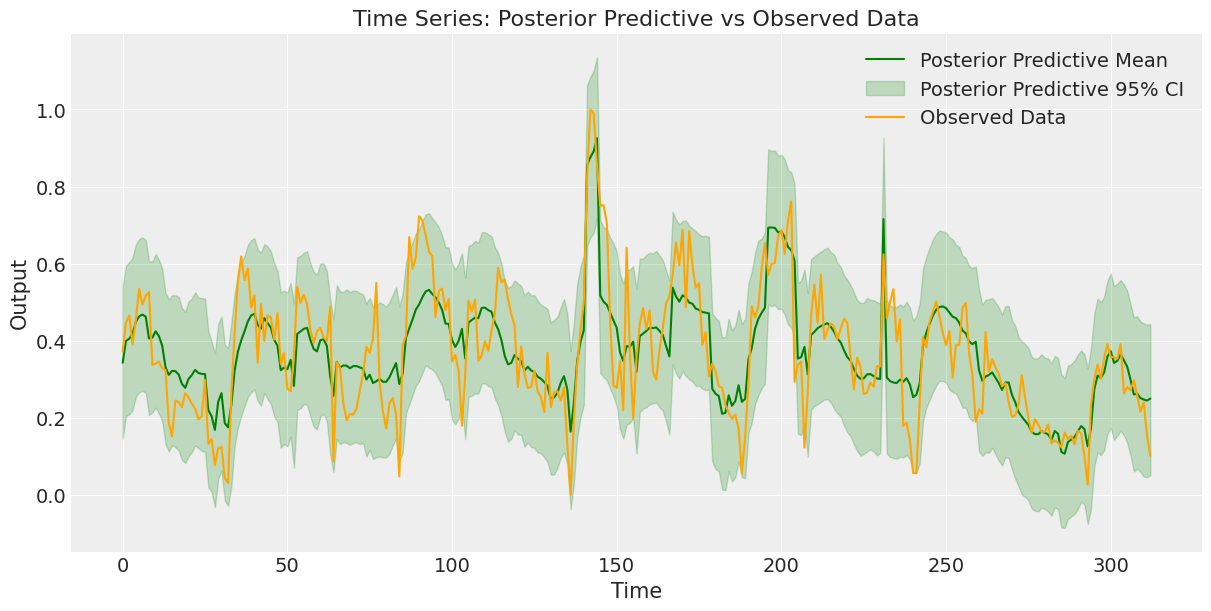

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_observed)), y_train_posterior_mean, color="green", label="Posterior Predictive Mean")
plt.fill_between(np.arange(len(y_observed)), y_train_posterior_lower, y_train_posterior_upper, color="green", alpha=0.2, label="Posterior Predictive 95% CI")
plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.title("Time Series: Posterior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(y_observed, y_train_posterior_mean)
r2 = r2_score(y_observed, y_train_posterior_mean)

print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE: 0.0094
R^2: 0.6692


### Posterior Variable Distribution

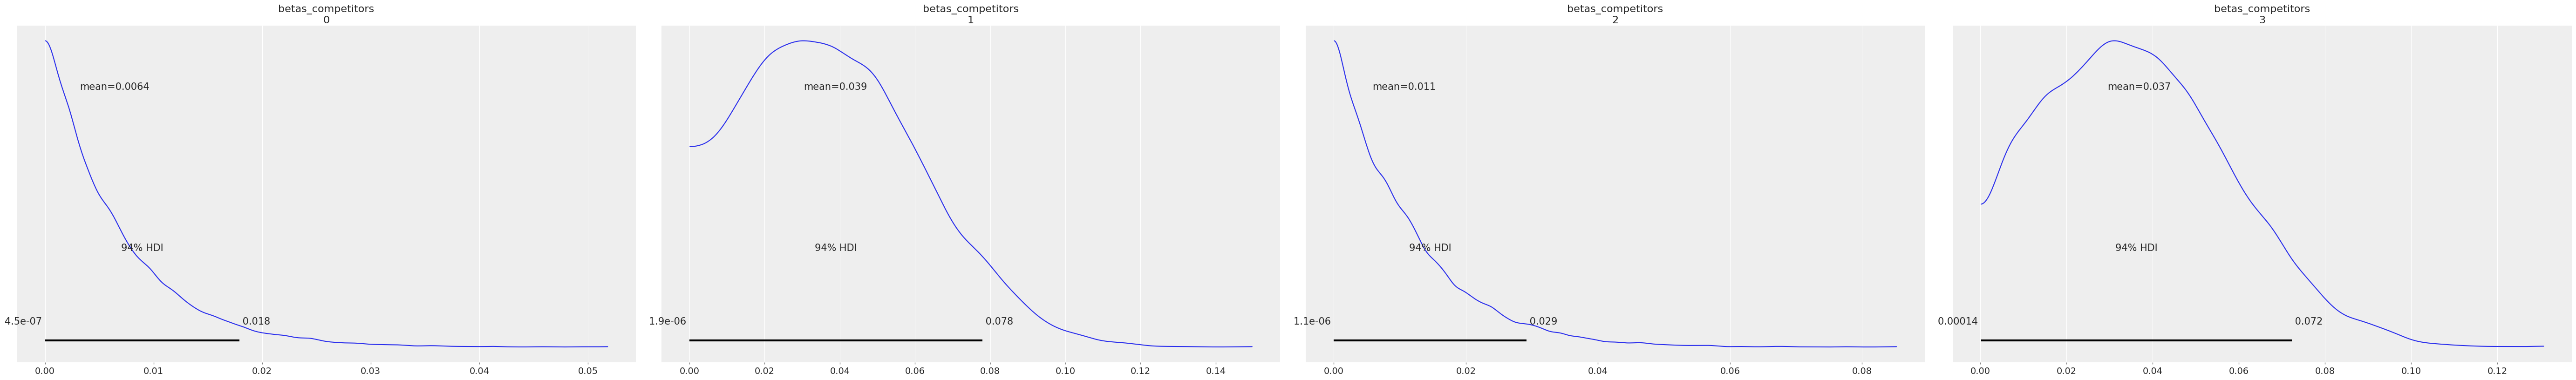

In [ ]:
pm.plot_posterior(trace, var_names=["betas_competitors"])
plt.show()

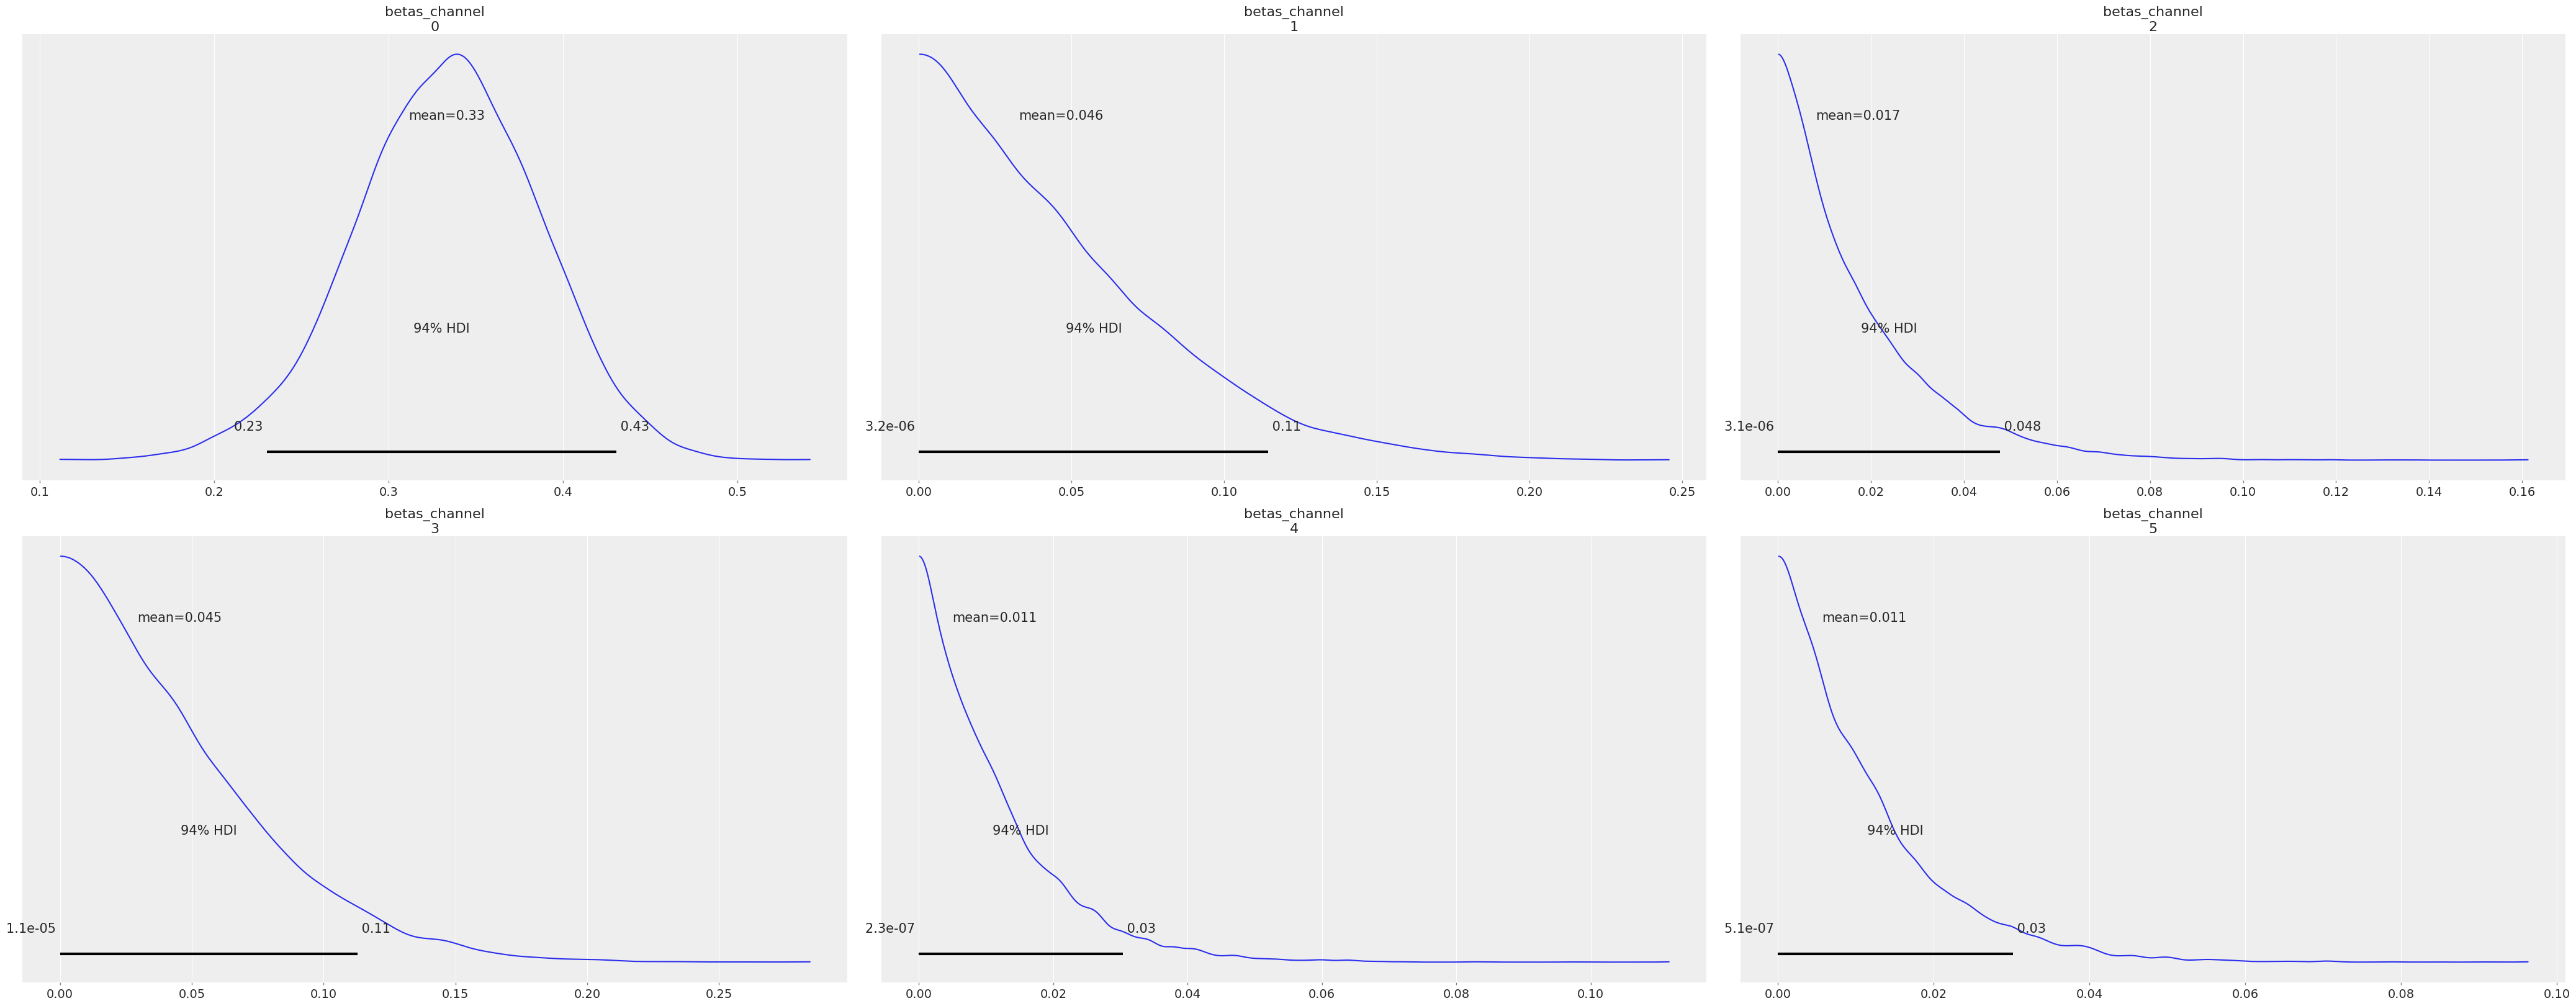

In [ ]:
pm.plot_posterior(trace, var_names=["betas_channel"])
plt.show()

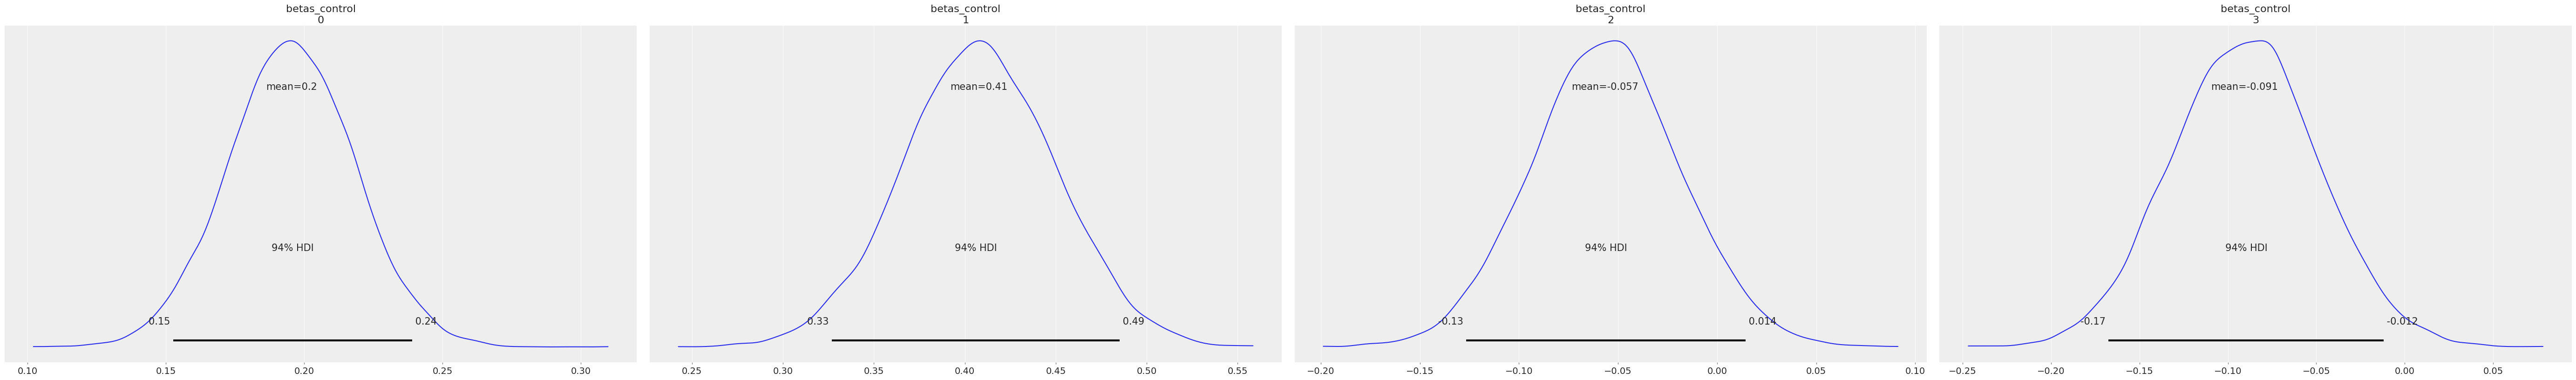

In [ ]:
pm.plot_posterior(trace, var_names=["betas_control"])
plt.show()

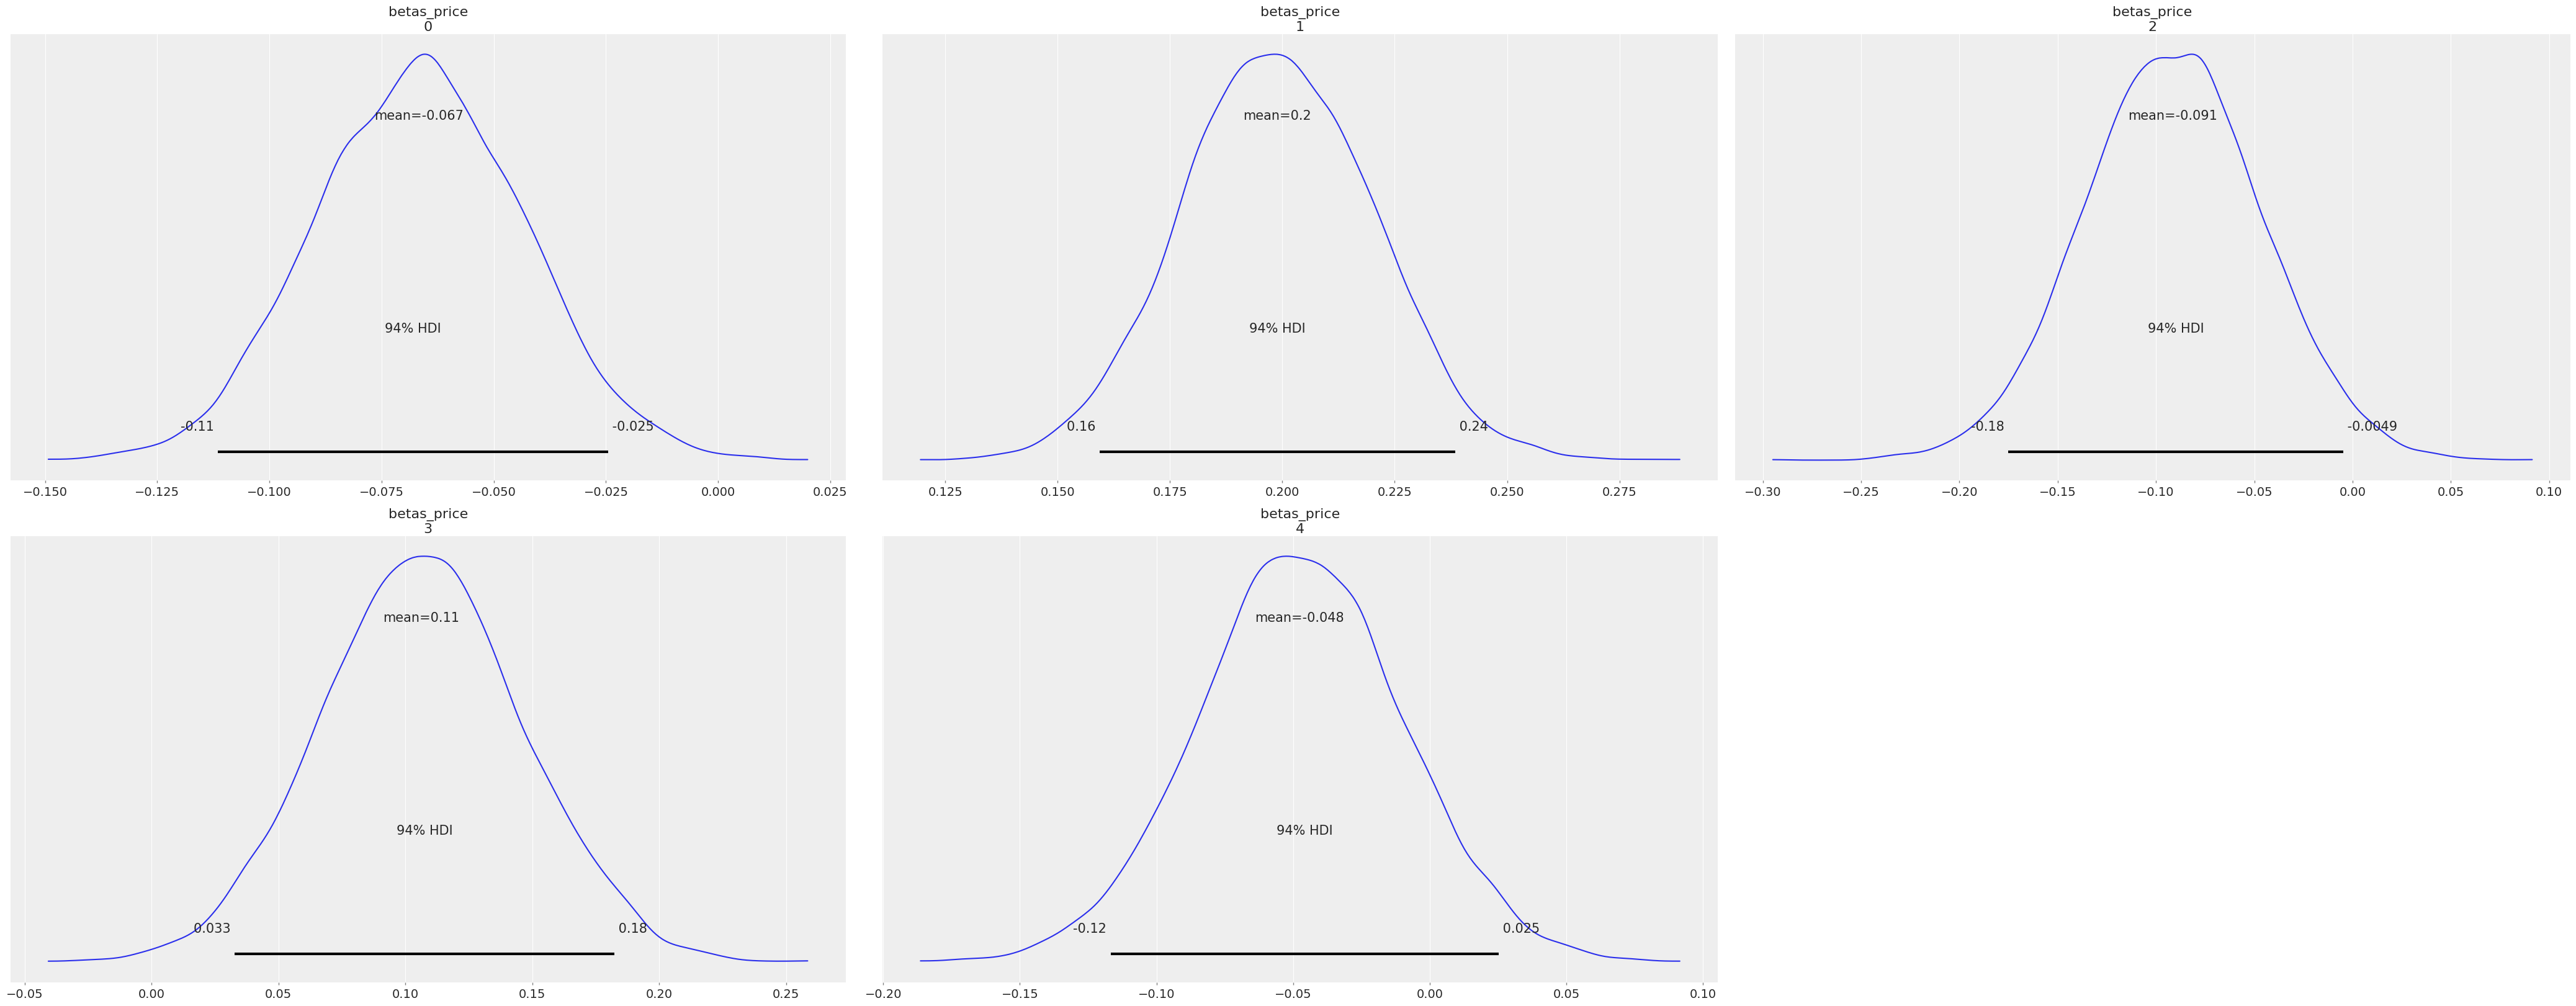

In [ ]:
pm.plot_posterior(trace, var_names=["betas_price"])
plt.show()

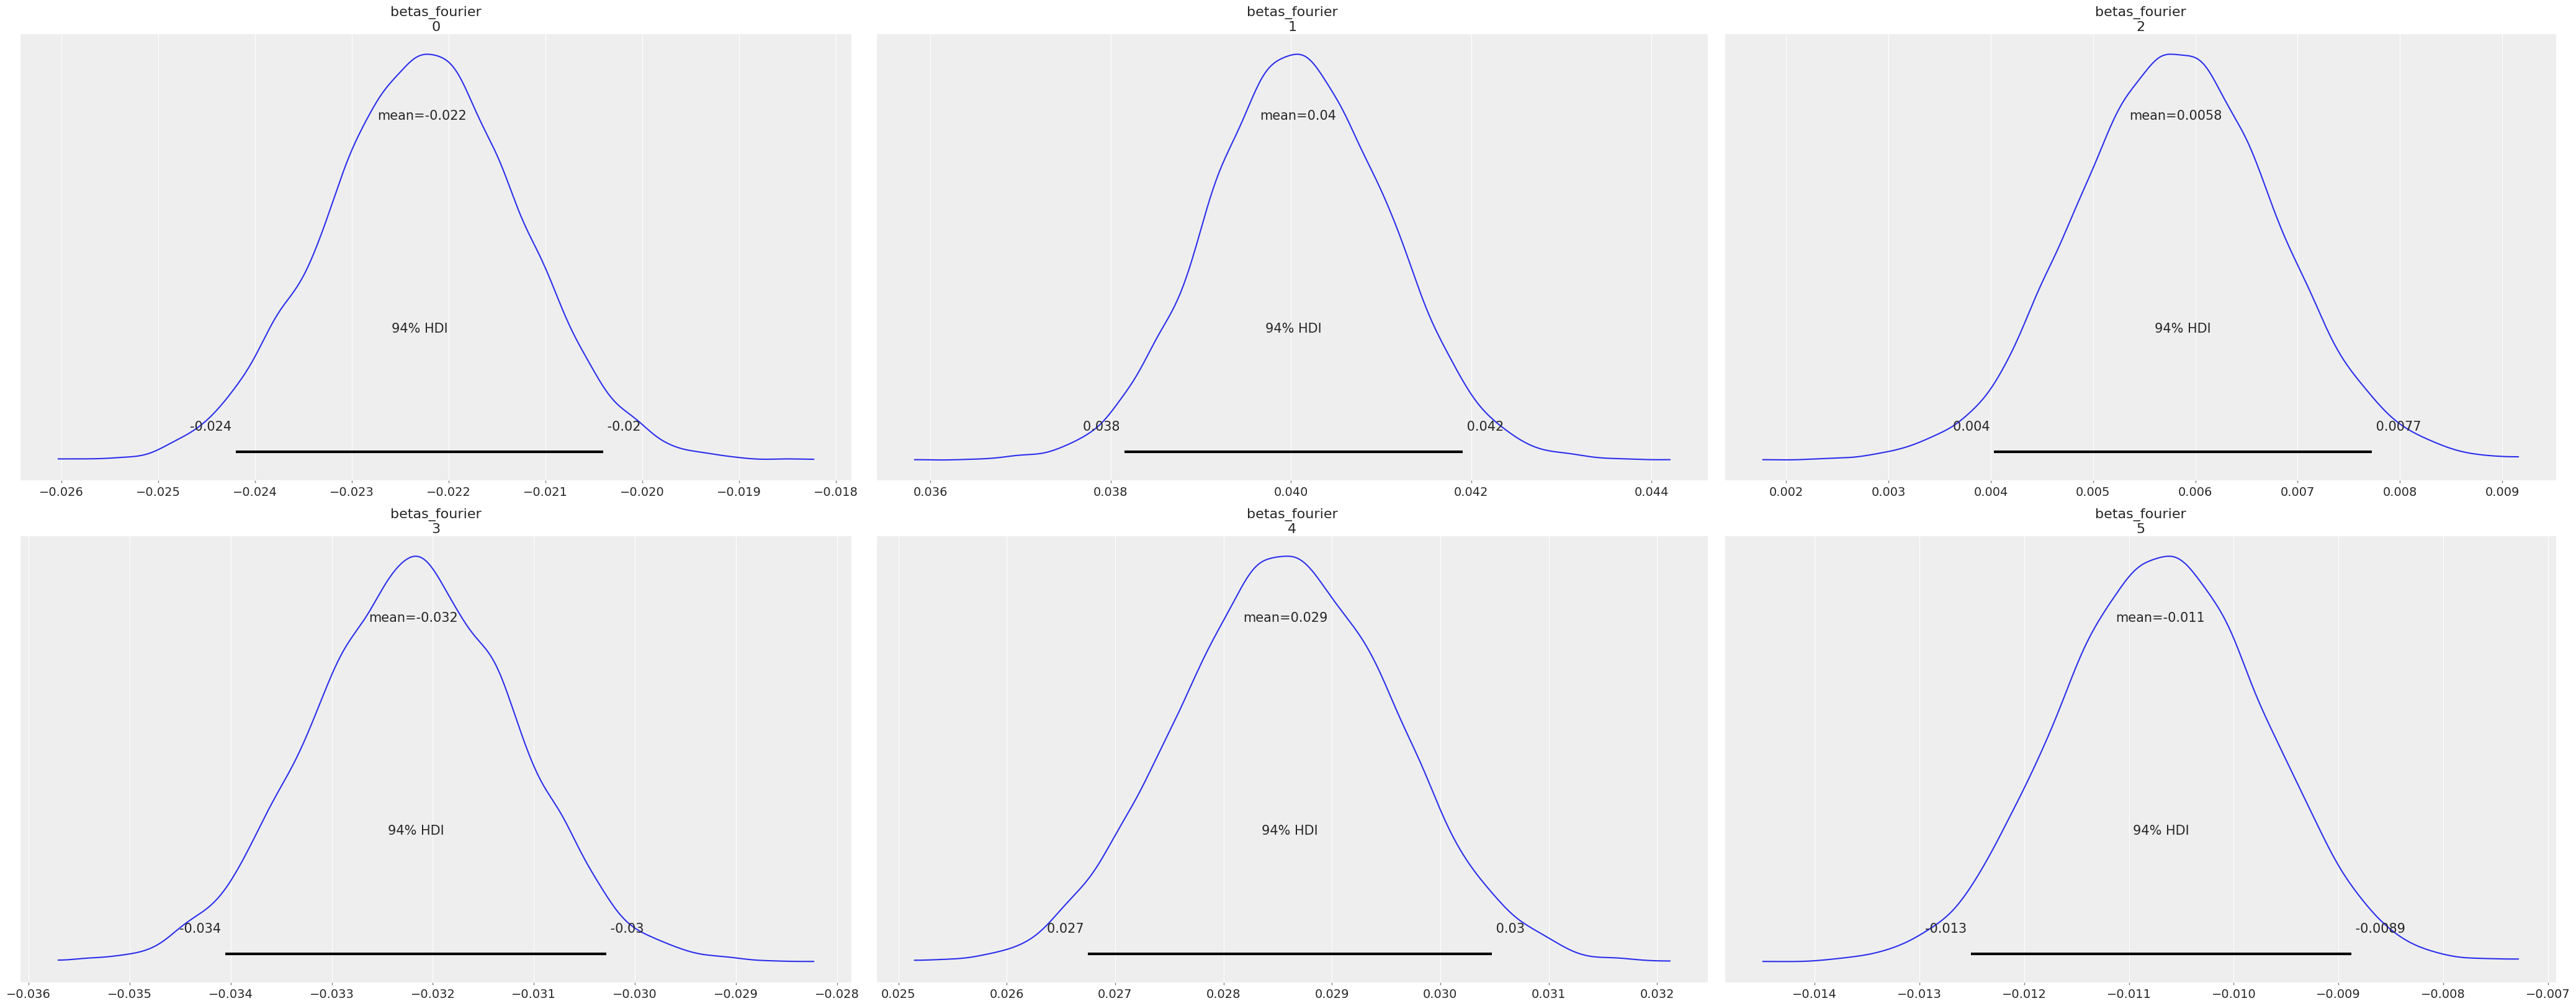

In [ ]:
pm.plot_posterior(trace, var_names=["betas_fourier"])
plt.show()

### Contribution Analysis

In [ ]:
betas_channel_mean = trace.posterior["betas_channel"].mean(dim=["chain", "draw"]).values
betas_control_mean = trace.posterior["betas_control"].mean(dim=["chain", "draw"]).values
betas_price_mean = trace.posterior["betas_price"].mean(dim=["chain", "draw"]).values
betas_fourier_mean = trace.posterior["betas_fourier"].mean(dim=["chain", "draw"]).values
betas_competitors_mean = -1*trace.posterior["betas_competitors"].mean(dim=["chain", "draw"]).values
lambda_mean = trace.posterior["lambda_params"].mean(dim=["chain", "draw"]).values
theta_mean = trace.posterior["theta_params"].mean(dim=["chain", "draw"]).values
intercept_mean = trace.posterior["intercept"].mean(dim=["chain", "draw"]).values

print("Posterior mean for channel betas:")
print(np.round(betas_channel_mean,2))
print("Posterior mean for price betas:")
print(np.round(betas_price_mean,2))
print("Posterior mean for control betas:")
print(np.round(betas_control_mean,2))
print("Posterior mean for competitors betas:")
print(np.round(betas_competitors_mean,2))
print("Posterior mean for fourier betas:")
print(np.round(betas_fourier_mean,2))
print("\nPosterior mean for intercept:")
print(np.round(intercept_mean,2))
print("\nPosterior mean for lambda_params:")
print(np.round(lambda_mean,2))
print("\nPosterior mean for theta_params:")
print(np.round(theta_mean,2))

Posterior mean for channel betas:
[0.33 0.05 0.02 0.05 0.01 0.01]
Posterior mean for price betas:
[-0.07  0.2  -0.09  0.11 -0.05]
Posterior mean for control betas:
[ 0.2   0.41 -0.06 -0.09]
Posterior mean for competitors betas:
[-0.01 -0.04 -0.01 -0.04]
Posterior mean for fourier betas:
[-0.02  0.04  0.01 -0.03  0.03 -0.01]

Posterior mean for intercept:
0.03

Posterior mean for lambda_params:
[20.   5.   0.2  5.   2.5  5. ]

Posterior mean for theta_params:
[0.2 0.3 0.3 0.8 0.8 0.8]


In [ ]:
fourier_contribution = np.dot(train_df_std[fourier_columns], betas_fourier_mean)
price_contribution = np.dot(train_df_std[price_columns], betas_price_mean)
competitors_contribution = np.dot(train_df_std[competitors_columns], betas_competitors_mean)
control_contribution = np.dot(train_df_std[control_columns], betas_control_mean)

In [ ]:
# Calcolo del contributo per media_columns
media_contribution = np.zeros(len(train_df_std))
for i, col in enumerate(media_columns):
    # Trasformazione saturazione e adstock
    x = train_df_std[col]
    x_transformed = logistic_saturation(x, lam=lambda_mean[i])
    x_transformed = adstock(x_transformed, theta=theta_mean[i])

    # Calcolo del contributo per la colonna
    media_contribution += np.dot(x_transformed, betas_channel_mean[i])

# Calcolo del contributo per tv_columns
tv_contribution = np.zeros(len(train_df_std))
for i, col in enumerate(tv_columns):
    # Trasformazione adstock e saturazione (ordine inverso rispetto a media_columns)
    x = train_df_std[col]
    x_transformed = adstock(x, theta=theta_mean[i])
    x_transformed = logistic_saturation(x_transformed, lam=lambda_mean[i])

    # Calcolo del contributo per la colonna
    tv_contribution += np.dot(x_transformed, betas_channel_mean[i])

In [ ]:
gaussian_process=np.mean(trace.posterior['f'], axis=(0, 1))
media_contribution_no_gp=media_contribution
media_contribution=media_contribution*gaussian_process
tv_contribution_no_gp=tv_contribution
tv_contribution=tv_contribution*gaussian_process

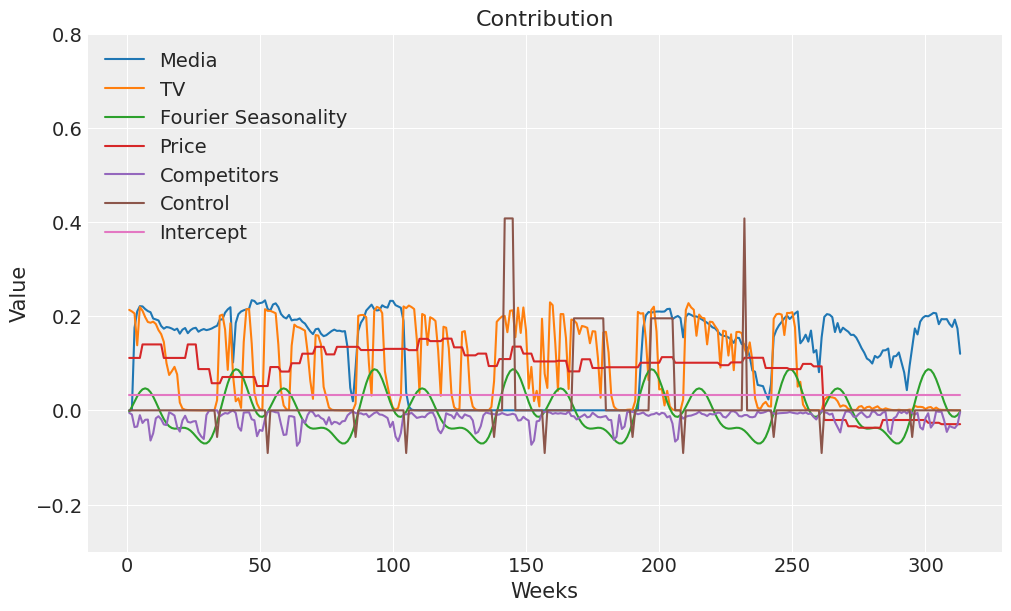

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], media_contribution, label='Media', color=colors[0])
plt.plot(train_df_std['t'], tv_contribution, label='TV', color=colors[1])
plt.plot(train_df_std['t'], fourier_contribution, label='Fourier Seasonality', color=colors[2])
plt.plot(train_df_std['t'], price_contribution, label='Price', color=colors[3])
plt.plot(train_df_std['t'], competitors_contribution, label='Competitors', color=colors[4])
plt.plot(train_df_std['t'], control_contribution, label='Control', color=colors[5])
plt.plot(train_df_std['t'], intercept_mean * np.ones(train_df_std.shape[0]), label='Intercept', color=colors[6])

plt.xlabel('Weeks')
plt.ylim(-0.3, 0.8)
plt.ylabel('Value')
plt.title('Contribution')
plt.legend()
plt.grid(True)
plt.show()

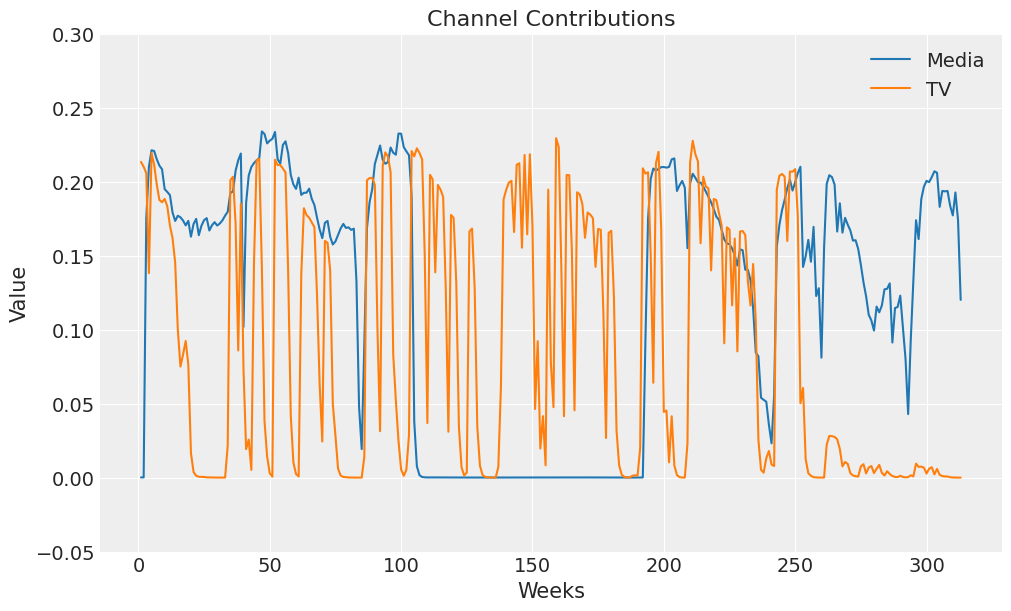

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], media_contribution, label='Media', color=colors[0])
plt.plot(train_df_std['t'], tv_contribution, label='TV', color=colors[1])

plt.xlabel('Weeks')
plt.ylim(-0.05, 0.3)
plt.ylabel('Value')
plt.title('Channel Contributions')
plt.legend()
plt.grid(True)
plt.show()

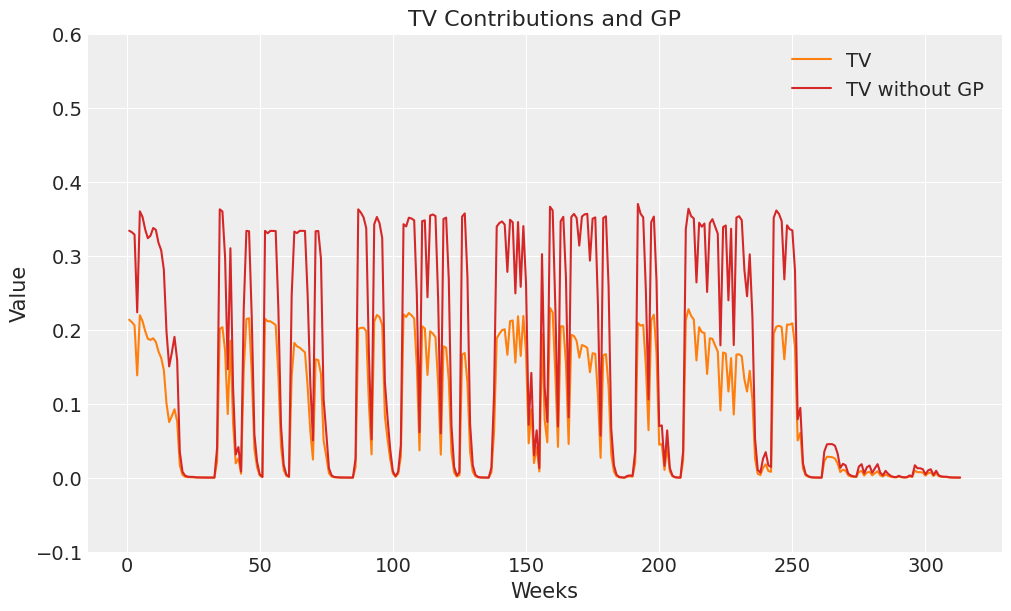

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], tv_contribution, label='TV', color=colors[1])
plt.plot(train_df_std['t'], tv_contribution_no_gp, label='TV without GP', color=colors[3])

plt.xlabel('Weeks')
plt.ylim(-0.1, 0.6)
plt.ylabel('Value')
plt.title('TV Contributions and GP')
plt.legend()
plt.grid(True)
plt.show()

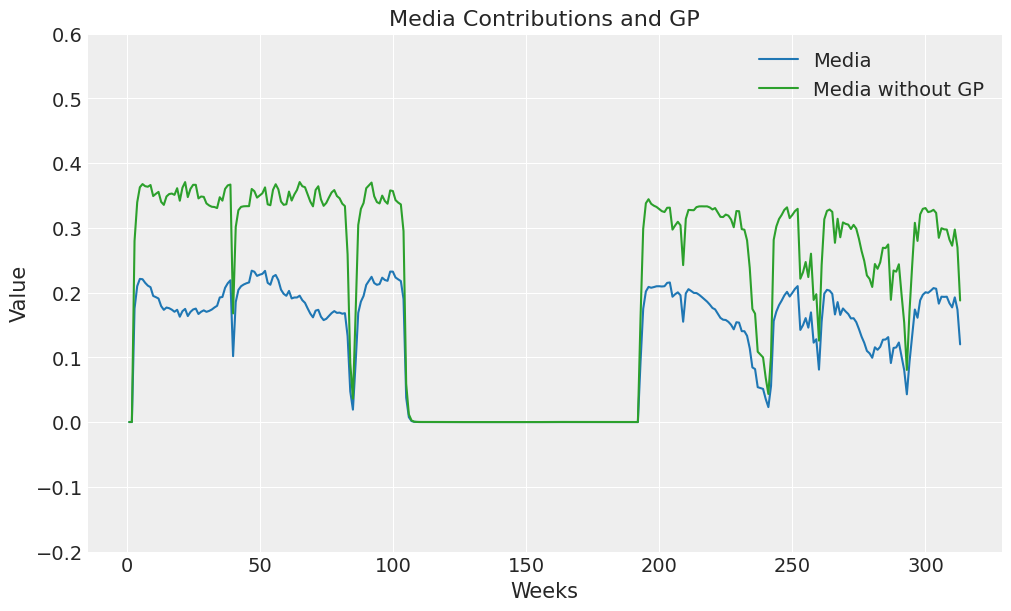

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], media_contribution, label='Media', color=colors[0])
plt.plot(train_df_std['t'], media_contribution_no_gp, label='Media without GP', color=colors[2])

plt.xlabel('Weeks')
plt.ylim(-0.2, 0.6)
plt.ylabel('Value')
plt.title('Media Contributions and GP')
plt.legend()
plt.grid(True)
plt.show()

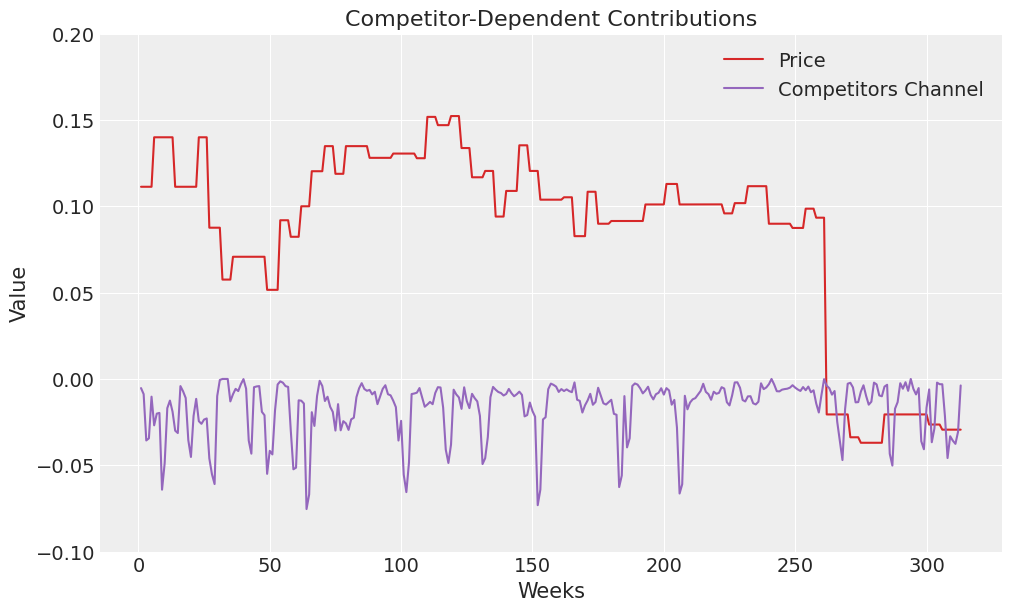

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], price_contribution, label='Price', color=colors[3])
plt.plot(train_df_std['t'], competitors_contribution, label='Competitors Channel', color=colors[4])

plt.xlabel('Weeks')
plt.ylim(-0.1, 0.2)
plt.ylabel('Value')
plt.title('Competitor-Dependent Contributions')
plt.legend()
plt.grid(True)
plt.show()

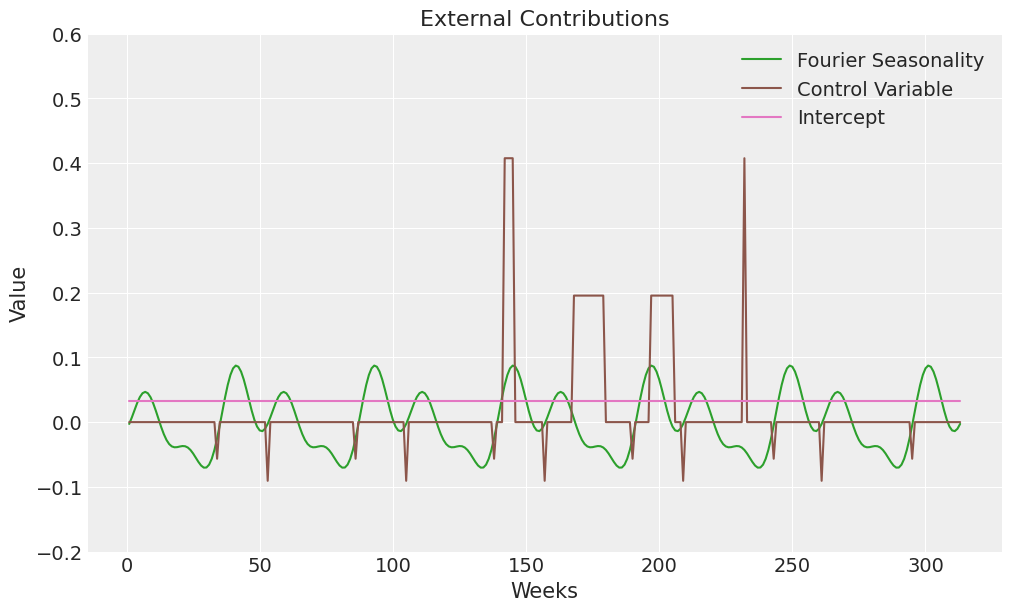

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], fourier_contribution, label='Fourier Seasonality', color=colors[2])
plt.plot(train_df_std['t'], control_contribution, label='Control Variable', color=colors[5])
plt.plot(train_df_std['t'], intercept_mean * np.ones(train_df_std.shape[0]), label='Intercept', color=colors[6])

plt.xlabel('Weeks')
plt.ylim(-0.2, 0.6)
plt.ylabel('Value')
plt.title('External Contributions')
plt.legend()
plt.grid(True)
plt.show()

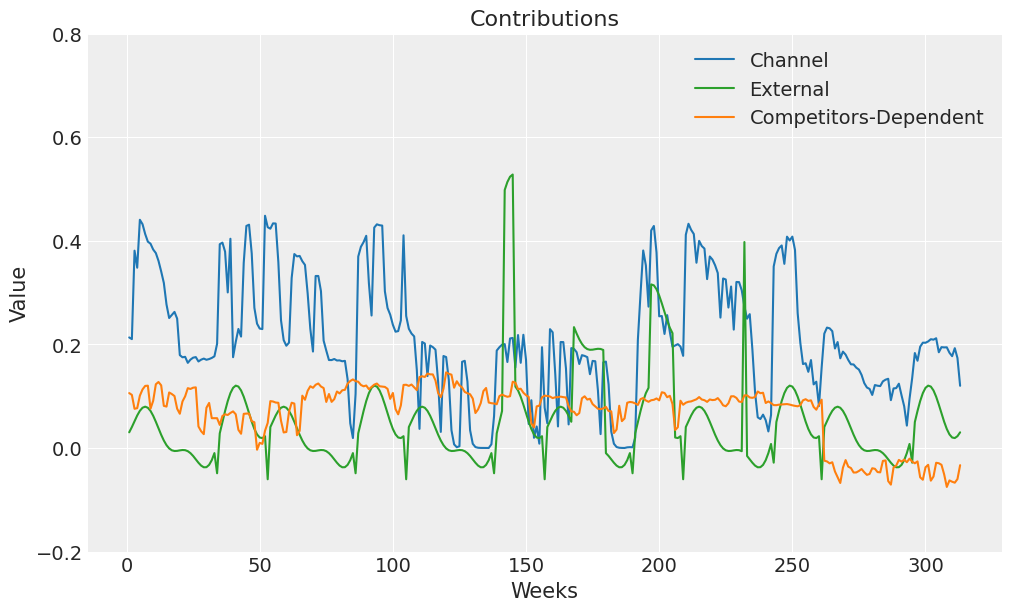

In [ ]:
#plor dei contributi
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))
plt.plot(train_df_std['t'], media_contribution+tv_contribution, label='Channel', color=colors[0])
plt.plot(train_df_std['t'], fourier_contribution+control_contribution+intercept_mean * np.ones(train_df_std.shape[0]), label='External', color=colors[2])
plt.plot(train_df_std['t'], price_contribution+competitors_contribution, label='Competitors-Dependent', color=colors[1])

plt.xlabel('Weeks')
plt.ylim(-0.2, 0.8)
plt.ylabel('Value')
plt.title('Contributions')
plt.legend()
plt.grid(True)
plt.show()

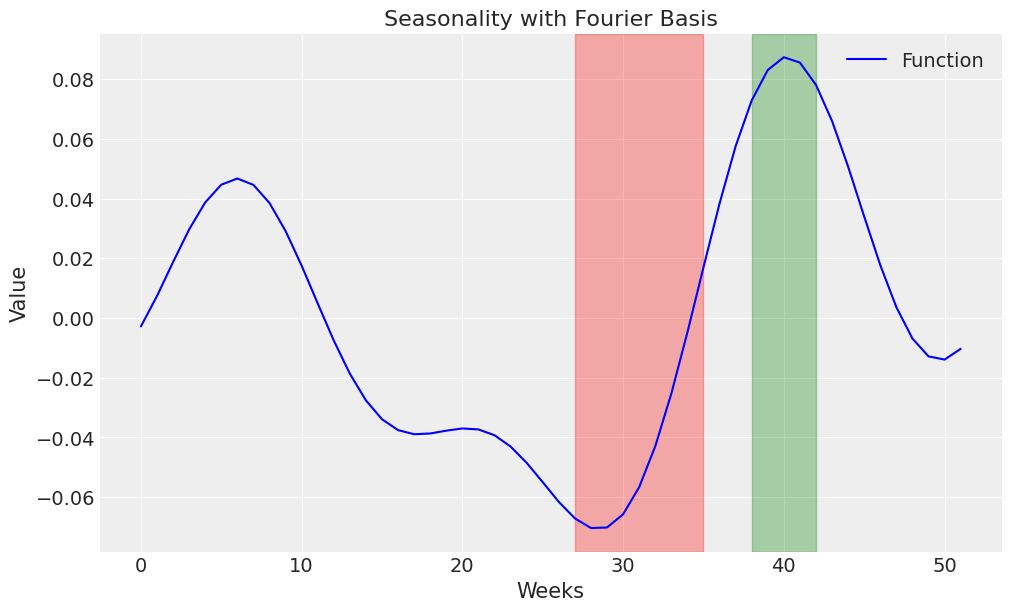

In [ ]:
time_index_year = time_index[:52]
# Plot della funzione ricostruita per un anno
plt.figure(figsize=(10, 6))
plt.plot(time_index_year, fourier_contribution[:52],  label='Function', color='blue')
plt.xlabel('Weeks')
plt.ylabel('Value')
plt.title('Seasonality with Fourier Basis')
plt.legend()
plt.grid(True)
plt.axvspan(27,35, color='red', alpha=0.3)
plt.axvspan(38,42, color='green', alpha=0.3)
plt.show()

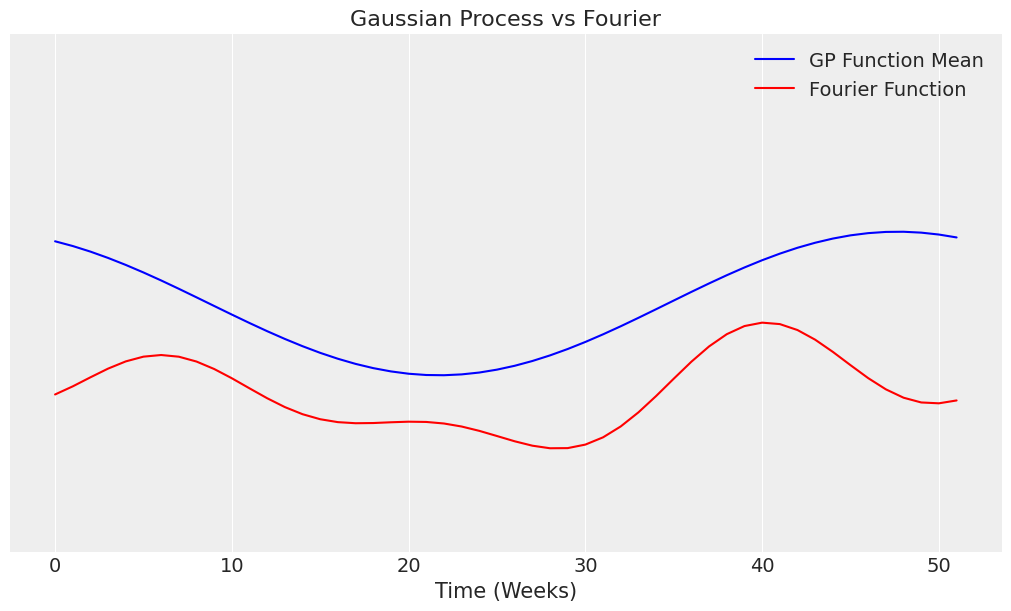

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_range, f_mean, color='blue', label='GP Function Mean')
plt.plot(time_index_year, fourier_contribution[:52]+0.45,  label='Fourier Function', color='red')
plt.yticks([])
plt.ylim(0.25, 0.9)
plt.title("Gaussian Process vs Fourier")
plt.xlabel("Time (Weeks)")
plt.legend()
plt.show()

### Test Set Prediction

In [ ]:
# Aggiungi Fourier al Test Set
time_index = np.arange(len(test_df_std))  # Ad esempio, ogni riga è un'osservazione temporale
for k in range(1, n_basis + 1):
    sin_col = f'sin_{k}'
    cos_col = f'cos_{k}'
    test_df_std[sin_col] = np.sin(2 * np.pi * k * time_index / 52)
    test_df_std[cos_col] = np.cos(2 * np.pi * k * time_index / 52)

In [ ]:
train_last_year = train_df_std.iloc[-104:]
empty_rows = pd.DataFrame(0, index=range(313-104-64), columns=train_df_std.columns)

In [ ]:
concatenated_df = pd.concat([train_last_year, test_df_std,empty_rows], axis=0)

In [ ]:
with model:
    pm.set_data({"X": concatenated_df, "y": concatenated_df["Output"].values})

In [ ]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace=trace)

Sampling: [y_obs]


Output()

In [ ]:
y_posterior = posterior_predictive["posterior_predictive"]["y_obs"].values
y_posterior_mean = np.mean(y_posterior, axis=(0, 1))
y_posterior_lower = np.percentile(y_posterior, 2.5, axis=(0, 1))
y_posterior_upper = np.percentile(y_posterior, 97.5, axis=(0, 1))


In [ ]:
y_test_pred=y_posterior_mean[104:168]
test_obs = concatenated_df.iloc[104:168]["Output"]
y_test_lower=y_posterior_lower[104:168]
y_test_upper=y_posterior_upper[104:168]

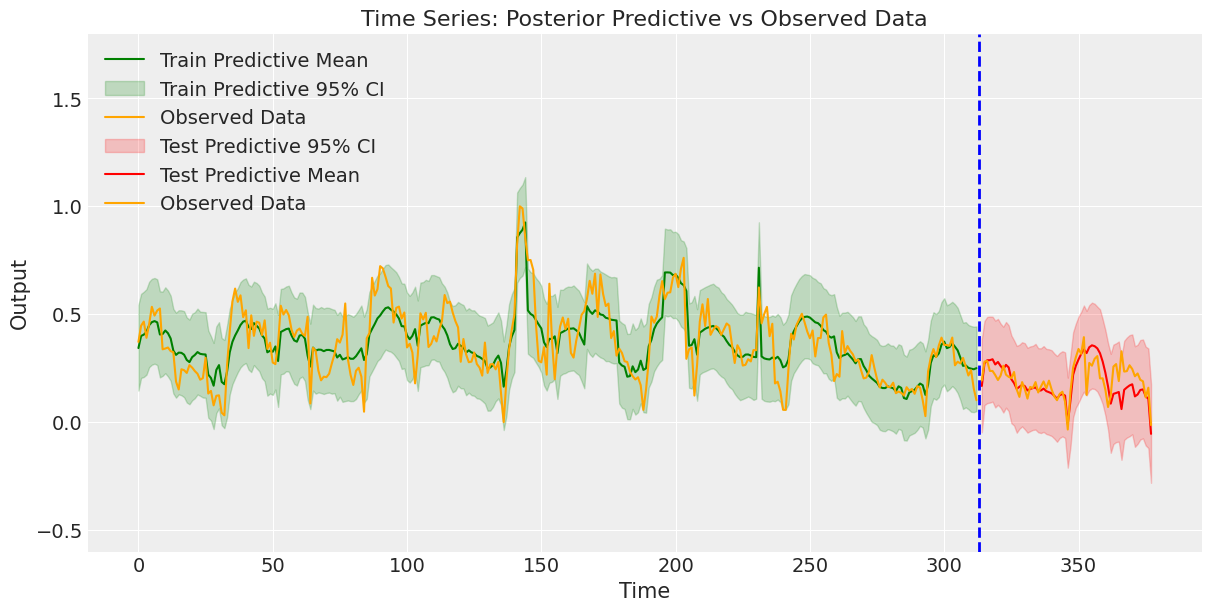

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_observed)), y_train_posterior_mean, color="green", label="Train Predictive Mean")
plt.fill_between(np.arange(len(y_observed)), y_train_posterior_lower, y_train_posterior_upper, color="green", alpha=0.2, label="Train Predictive 95% CI")
plt.plot(np.arange(len(y_observed)), y_observed, color="orange", label="Observed Data")
plt.fill_between(test_df_std["t"], y_test_lower, y_test_upper, color="red", alpha=0.2, label="Test Predictive 95% CI")
plt.plot(test_df_std["t"], y_test_pred, color="red", label="Test Predictive Mean")
plt.plot(test_df_std["t"],test_df_std["Output"] , color="orange", label="Observed Data")
plt.axvline(x=313, color='blue', linestyle='--', linewidth=2)
plt.title("Time Series: Posterior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylim(-0.6, 1.8)
plt.ylabel("Output")
plt.legend(loc="upper left")
plt.show()

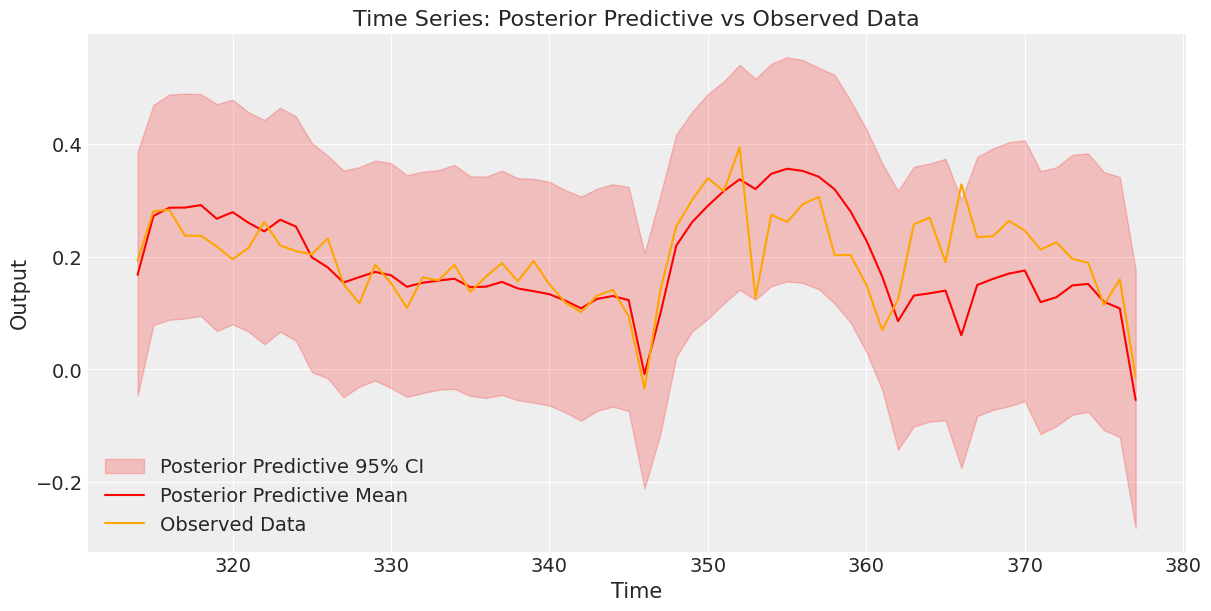

In [ ]:
plt.figure(figsize=(12, 6))
plt.fill_between(test_df_std["t"], y_test_lower, y_test_upper, color="red", alpha=0.2, label="Posterior Predictive 95% CI")
plt.plot(test_df_std["t"], y_test_pred, color="red", label="Posterior Predictive Mean")

plt.plot(test_df_std["t"],test_df_std["Output"] , color="orange", label="Observed Data")
plt.title("Time Series: Posterior Predictive vs Observed Data")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

### Scaling

rescale the values with the inverse minmax scaled applied before the model (min and max from training set)

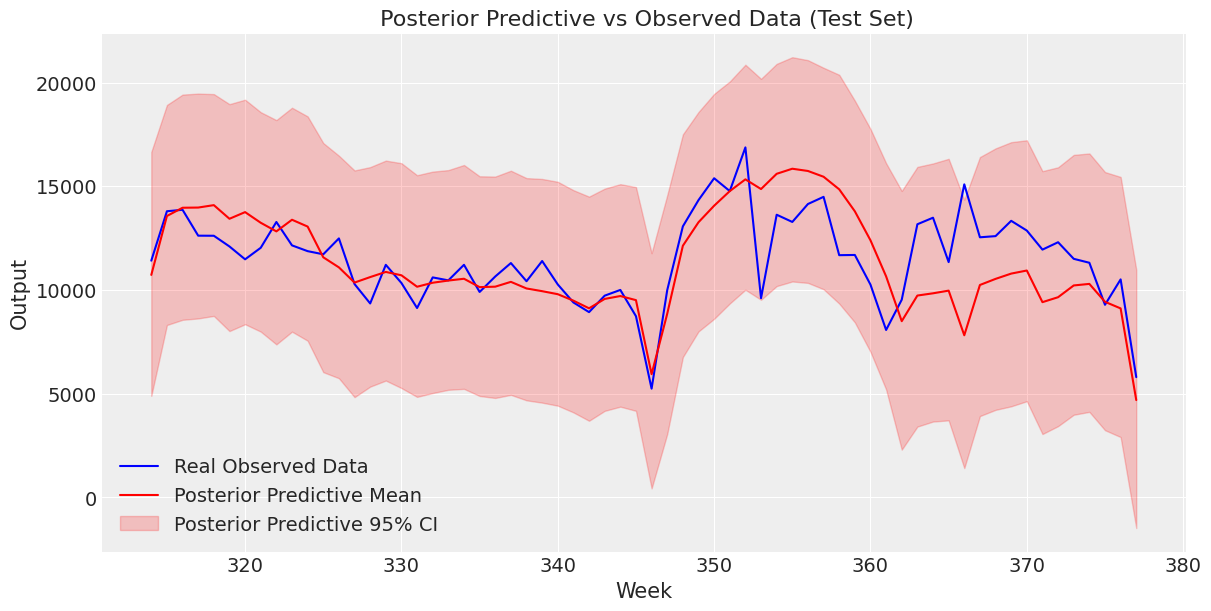

In [ ]:
y_true = np.array(test_df_std["Output"])
y_pred = np.array(y_test_pred)
y_lower = np.array(y_test_lower)
y_upper = np.array(y_test_upper)

y_true_rescaled = y_true * (train_df['Output'].max() - train_df['Output'].min()) + train_df['Output'].min()
y_pred_rescaled = y_pred * (train_df['Output'].max() - train_df['Output'].min()) + train_df['Output'].min()
y_lower_rescaled = y_lower * (train_df['Output'].max() - train_df['Output'].min()) + train_df['Output'].min()
y_upper_rescaled = y_upper * (train_df['Output'].max() - train_df['Output'].min()) + train_df['Output'].min()

plt.figure(figsize=(12, 6))
plt.plot(test_df_std["t"], y_true_rescaled, color="blue", label="Real Observed Data")
plt.plot(test_df_std["t"], y_pred_rescaled, color="red", label="Posterior Predictive Mean")
plt.fill_between(test_df_std["t"], y_lower_rescaled, y_upper_rescaled, color="red", alpha=0.2, label="Posterior Predictive 95% CI")
plt.xlabel("Week")
plt.title(" Posterior Predictive vs Observed Data (Test Set)")
plt.ylabel("Output")
plt.legend()
plt.show()


In [ ]:
# Calcolare R²
r2 = r2_score(y_true_rescaled, y_pred_rescaled)

# Calcolare MAE
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)

# Calcolare MAPE (evita divisione per 0)
mape = np.mean(np.abs((y_true_rescaled - y_pred_rescaled) / y_true_rescaled)) * 100

# Stampa dei risultati
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

R²: 0.2138
MAE: 1363.9828
MAPE: 11.7472


In [ ]:
vec_r2=np.zeros(y_true_rescaled.shape[0])
vec_mae=np.zeros(y_true_rescaled.shape[0])
vec_mape=np.zeros(y_true_rescaled.shape[0])
for i in range(1,y_true_rescaled.shape[0]+1):
    vec_r2[i-1] = r2_score(y_true_rescaled[:i], y_pred_rescaled[:i])
    vec_mae[i-1] = mean_absolute_error(y_true_rescaled[:i], y_pred_rescaled[:i])
    vec_mape[i-1] = np.mean(np.abs((y_true_rescaled[:i] - y_pred_rescaled[:i]) / y_true_rescaled[:i])) * 100

/home/alessandro/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


/tmp/ipykernel_11997/2339586743.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


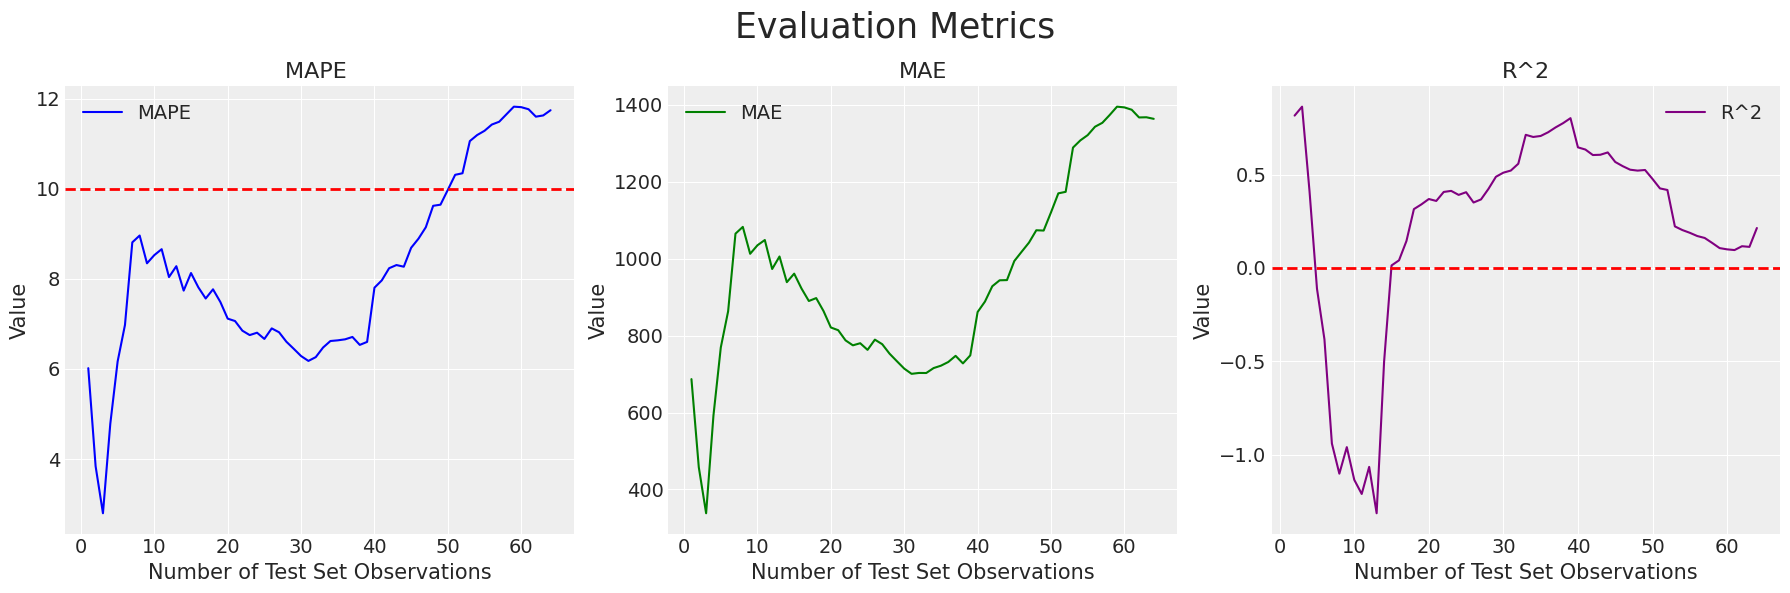

In [ ]:
import matplotlib.pyplot as plt

# Crea una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Primo grafico
axs[0].plot(range(1, y_true_rescaled.shape[0] + 1), vec_mape, color="blue")
axs[0].set_title("MAPE ")
axs[0].set_xlabel("Number of Test Set Observations")
axs[0].set_ylabel("Value")
axs[0].axhline(y=10, color='r', linestyle='--', linewidth=2)
axs[0].legend(["MAPE"])

# Secondo grafico (puoi sostituire con un altro vettore o set di dati)
axs[1].plot(range(1, y_true_rescaled.shape[0] + 1), vec_mae, color="green")
axs[1].set_title("MAE")
axs[1].set_xlabel("Number of Test Set Observations")
axs[1].set_ylabel("Value")
axs[1].legend(["MAE"])

# Terzo grafico (puoi sostituire con un altro vettore o set di dati)
axs[2].plot(range(1, y_true_rescaled.shape[0] + 1), vec_r2, color="purple")
axs[2].set_title("R^2")
axs[2].set_xlabel("Number of Test Set Observations")
axs[2].set_ylabel("Value")
axs[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axs[2].legend(["R^2"])

# Impostiamo un titolo generale per la figura
fig.suptitle('Evaluation Metrics', fontsize=25)

# Ottimizzazione del layout
plt.tight_layout()

# Mostriamo i grafici
plt.show()

/tmp/ipykernel_11997/2694554964.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


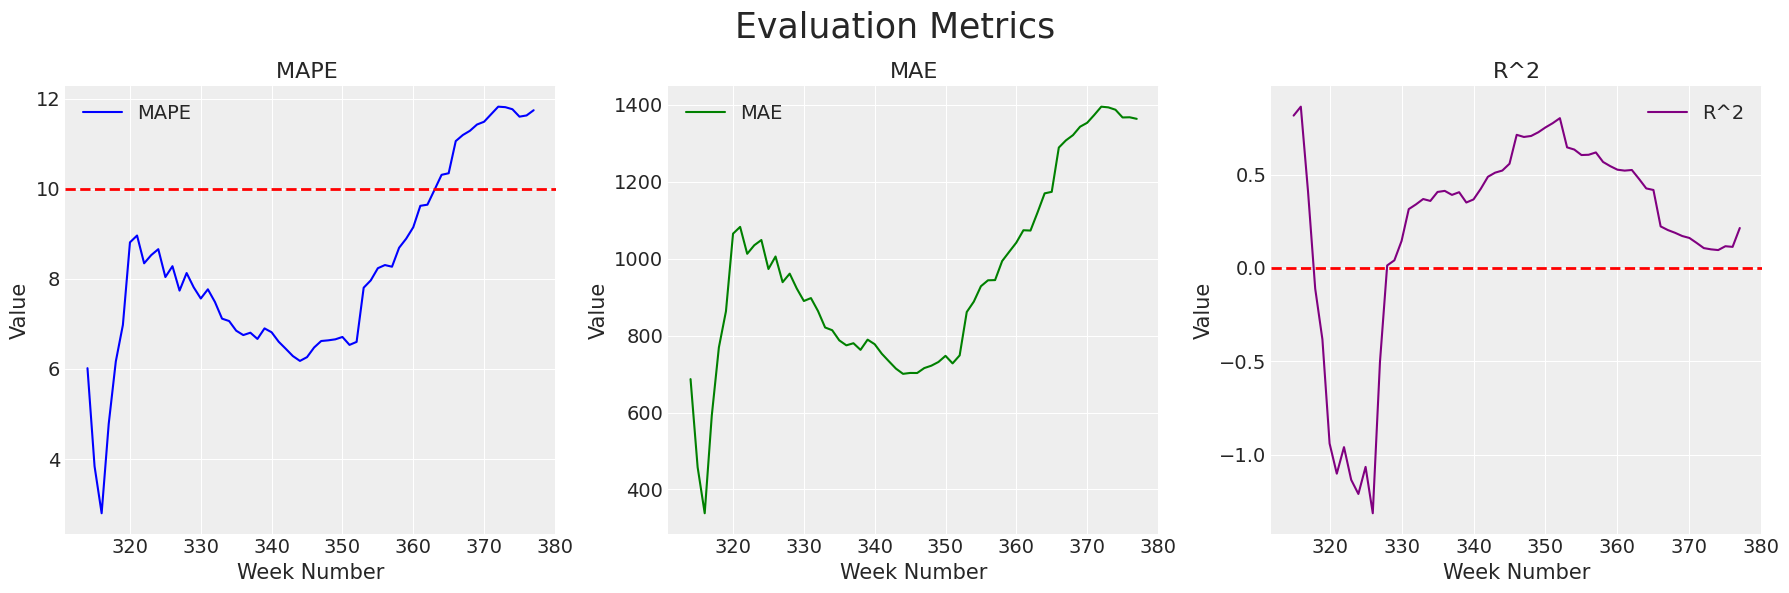

In [ ]:
import matplotlib.pyplot as plt

# Crea una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Primo grafico
axs[0].plot(test_df_std["t"], vec_mape, color="blue")
axs[0].set_title("MAPE ")
axs[0].set_xlabel("Week Number")
axs[0].set_ylabel("Value")
axs[0].axhline(y=10, color='r', linestyle='--', linewidth=2)
axs[0].legend(["MAPE"])

# Secondo grafico (puoi sostituire con un altro vettore o set di dati)
axs[1].plot(test_df_std["t"], vec_mae, color="green")
axs[1].set_title("MAE")
axs[1].set_xlabel("Week Number")
axs[1].set_ylabel("Value")
axs[1].legend(["MAE"])

# Terzo grafico (puoi sostituire con un altro vettore o set di dati)
axs[2].plot(test_df_std["t"], vec_r2, color="purple")
axs[2].set_title("R^2")
axs[2].set_xlabel("Week Number")
axs[2].set_ylabel("Value")
axs[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axs[2].legend(["R^2"])

# Impostiamo un titolo generale per la figura
fig.suptitle('Evaluation Metrics', fontsize=25)

# Ottimizzazione del layout
plt.tight_layout()

# Mostriamo i grafici
plt.show()